In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import re

# Funzione per estrarre e convertire i valori dell'ottava colonna in liste di float
def get_eight_column_values(df, type_val, module_val, name_val):
    filtered_df = df[(df['type'] == type_val) & (df['module'] == module_val) & (df['name'] == name_val)]
    if filtered_df.empty:
        return None
    values = filtered_df.iloc[:, 7].str.split().apply(lambda x: list(map(float, x)))
    return values.explode().astype(float).values

# Funzione per estrarre e convertire i valori dell'ottava colonna in liste di float
def get_seventh_column_values(df, type_val, module_val, name_val):
    filtered_df = df[(df['type'] == type_val) & (df['module'] == module_val) & (df['name'] == name_val)]
    if filtered_df.empty:
        return None
    values = filtered_df.iloc[:, 6].str.split().apply(lambda x: list(map(float, x)))
    return values.explode().astype(float).values

# Funzione per calcolare l'intervallo di confidenza
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    margin = sem * stats.t.ppf((1 + confidence) / 2, len(data) - 1)
    return mean, mean - margin, mean + margin

# Funzione per rimuovere '_vec' dalla fine del nome del file
def remove_vec_suffix(file_name):
    if file_name.endswith('_vec.csv'):
        return file_name[:-8]
    else:
        return file_name

# Funzione per ottenere il numero finale dal nome del file
def get_file_number(file_name):
    match = re.search(r'\d+$', file_name)
    if match:
        return int(match.group())
    else:
        return 0  # Se non viene trovato nessun numero, restituisci 0

# Funzione per analizzare un singolo file CSV
def analyze_csv(file_path, ignored_files, results):
    df = pd.read_csv(file_path)
    description = df[df['attrname'] == 'description']['attrvalue'].values
    description = description[0] if len(description) > 0 else "N/A"

    is_N = any("N=1" in val for val in df[df['attrname'] == 'description']['attrvalue'].values)

    pDistribution = get_eight_column_values(df, "vector", "TandemQueueSystem.Server", "pDistribution")
    vDistribution = get_eight_column_values(df, "vector", "TandemQueueSystem.Server", "vDistribution")
    lifeTime = get_eight_column_values(df, "vector", "TandemQueueSystem.sink", "lifeTime:vector")
    lifeTime_arrival = get_seventh_column_values(df, "vector", "TandemQueueSystem.sink", "lifeTime:vector")

    if pDistribution is None or vDistribution is None or lifeTime is None:
        ignored_files.append((remove_vec_suffix(os.path.basename(file_path)), description))
        return

    min_length = min(len(pDistribution), len(vDistribution), len(lifeTime))
    pDistribution = pDistribution[:min_length]
    vDistribution = vDistribution[:min_length]
    lifeTime = lifeTime[:min_length]

    queueLength_Q1 = get_eight_column_values(df, "vector", "TandemQueueSystem.Q1", "queueLength:vector")
    queueLength_Q2 = get_eight_column_values(df, "vector", "TandemQueueSystem.Q2", "queueLength:vector")

    if is_N:
        queueLength_Q2 = np.zeros(len(queueLength_Q1))
    else: 
        if queueLength_Q1 is None or queueLength_Q2 is None:
                ignored_files.append((remove_vec_suffix(os.path.basename(file_path)), description))
                return

    Cw = 1  # Definisci il valore di Cw

    mean_W, ci_low_W, ci_high_W = confidence_interval(lifeTime)
    U_values = vDistribution - pDistribution - (Cw * lifeTime)
    mean_U, ci_low_U, ci_high_U = confidence_interval(U_values)
    max_W = np.max(lifeTime)
    min_W = np.min(lifeTime)
    mean_max_W, ci_low_max_W, ci_high_max_W = confidence_interval(lifeTime, confidence=0.95)
    mean_min_W, ci_low_min_W, ci_high_min_W = confidence_interval(lifeTime, confidence=0.95)
    mean_queueLength_Q1 = np.mean(queueLength_Q1)
    mean_queueLength_Q2 = np.mean(queueLength_Q2)
    mean_utilization_Q1, ci_low_utilization_Q1, ci_high_utilization_Q1 = confidence_interval(queueLength_Q1 / np.sum(queueLength_Q1))
    mean_utilization_Q2, ci_low_utilization_Q2, ci_high_utilization_Q2 = confidence_interval(queueLength_Q2 / np.sum(queueLength_Q2))

    results.append({
        "File": remove_vec_suffix(os.path.basename(file_path)),
        "File_Number": get_file_number(remove_vec_suffix(os.path.basename(file_path))),
        "Description": description,
        "mean_W": mean_W,
        "ci_low_W": ci_low_W,
        "ci_high_W": ci_high_W,
        "mean_U": mean_U,
        "ci_low_U": ci_low_U,
        "ci_high_U": ci_high_U,
        "max_W": max_W,
        "ci_low_max_W": ci_low_max_W,
        "ci_high_max_W": ci_high_max_W,
        "min_W": min_W,
        "ci_low_min_W": ci_low_min_W,
        "ci_high_min_W": ci_high_min_W,
        "mean_utilization_Q1": mean_utilization_Q1,
        "ci_low_utilization_Q1": ci_low_utilization_Q1,
        "ci_high_utilization_Q1": ci_high_utilization_Q1,
        "mean_utilization_Q2": mean_utilization_Q2,
        "ci_low_utilization_Q2": ci_low_utilization_Q2,
        "ci_high_utilization_Q2": ci_high_utilization_Q2,
        "mean_queueLength_Q1": mean_queueLength_Q1,
        "mean_queueLength_Q2": mean_queueLength_Q2,
        "lifeTime": ",".join(map(str, lifeTime)),
        "lifeTime_arrival": ",".join(map(str, lifeTime_arrival))
    })

# Funzione per analizzare tutti i file CSV in una directory
def analyze_directory(directory_path):
    ignored_files = []
    results = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv') and not file_name.endswith('_sca.csv'):
            file_path = os.path.join(directory_path, file_name)
            analyze_csv(file_path, ignored_files, results)
    
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by='File_Number')  # Ordina per numero del file
        results_df.drop(columns=['File_Number'], inplace=True)  # Rimuovi la colonna File_Number
        results_df.to_csv(os.path.join('./results_summary.csv'), index=False)
    
    if ignored_files:
        ignored_files_sorted = sorted(ignored_files, key=lambda x: get_file_number(x[0]))  # Ordina gli ignorati per numero del file
        ignored_df = pd.DataFrame(ignored_files_sorted, columns=['File', 'Description'])
        ignored_df.to_csv(os.path.join('./ignored_files.csv'), index=False)

# Esempio di utilizzo
directory_path = './results_CSV'
analyze_directory(directory_path)


/tmp/ipykernel_208371/3668100931.py:89: RuntimeWarning: invalid value encountered in divide
  mean_utilization_Q2, ci_low_utilization_Q2, ci_high_utilization_Q2 = confidence_interval(queueLength_Q2 / np.sum(queueLength_Q2))
/tmp/ipykernel_208371/3668100931.py:89: RuntimeWarning: invalid value encountered in divide
  mean_utilization_Q2, ci_low_utilization_Q2, ci_high_utilization_Q2 = confidence_interval(queueLength_Q2 / np.sum(queueLength_Q2))
/tmp/ipykernel_208371/3668100931.py:89: RuntimeWarning: invalid value encountered in divide
  mean_utilization_Q2, ci_low_utilization_Q2, ci_high_utilization_Q2 = confidence_interval(queueLength_Q2 / np.sum(queueLength_Q2))
/tmp/ipykernel_208371/3668100931.py:89: RuntimeWarning: invalid value encountered in divide
  mean_utilization_Q2, ci_low_utilization_Q2, ci_high_utilization_Q2 = confidence_interval(queueLength_Q2 / np.sum(queueLength_Q2))
/tmp/ipykernel_208371/3668100931.py:89: RuntimeWarning: invalid value encountered in divide
  mean_utili

Studio Transiente Iniziale

Transiente iniziale per mean_W (Strategy=0): 0.446155211863
Transiente iniziale per utilization_Q1 (Strategy=0): 0.446155211863
Transiente iniziale per utilization_Q2 (Strategy=0): 1.675220032802
Transiente iniziale per queue_length_Q1 (Strategy=0): 0.446155211863
Transiente iniziale per queue_length_Q2 (Strategy=0): 0.446155211863
Media dei transienti iniziali (Strategy=0): 0.6919681760508001


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


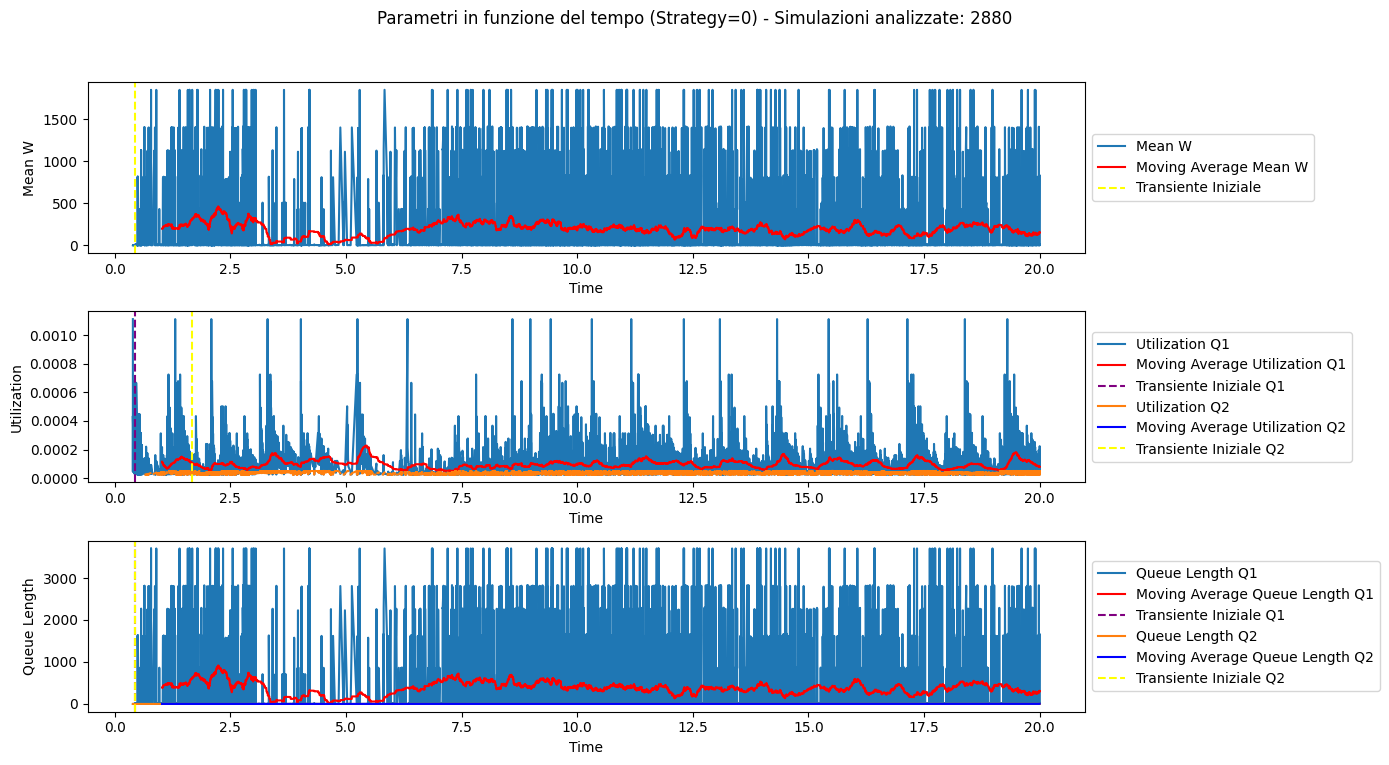

Transiente iniziale per mean_W (Strategy=1): 0.392925949277
Transiente iniziale per utilization_Q1 (Strategy=1): 0.392925949277
Transiente iniziale per utilization_Q2 (Strategy=1): 5.583427482021
Transiente iniziale per queue_length_Q1 (Strategy=1): 0.392925949277
Transiente iniziale per queue_length_Q2 (Strategy=1): 0.392925949277
Media dei transienti iniziali (Strategy=1): 1.4310262558258002


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


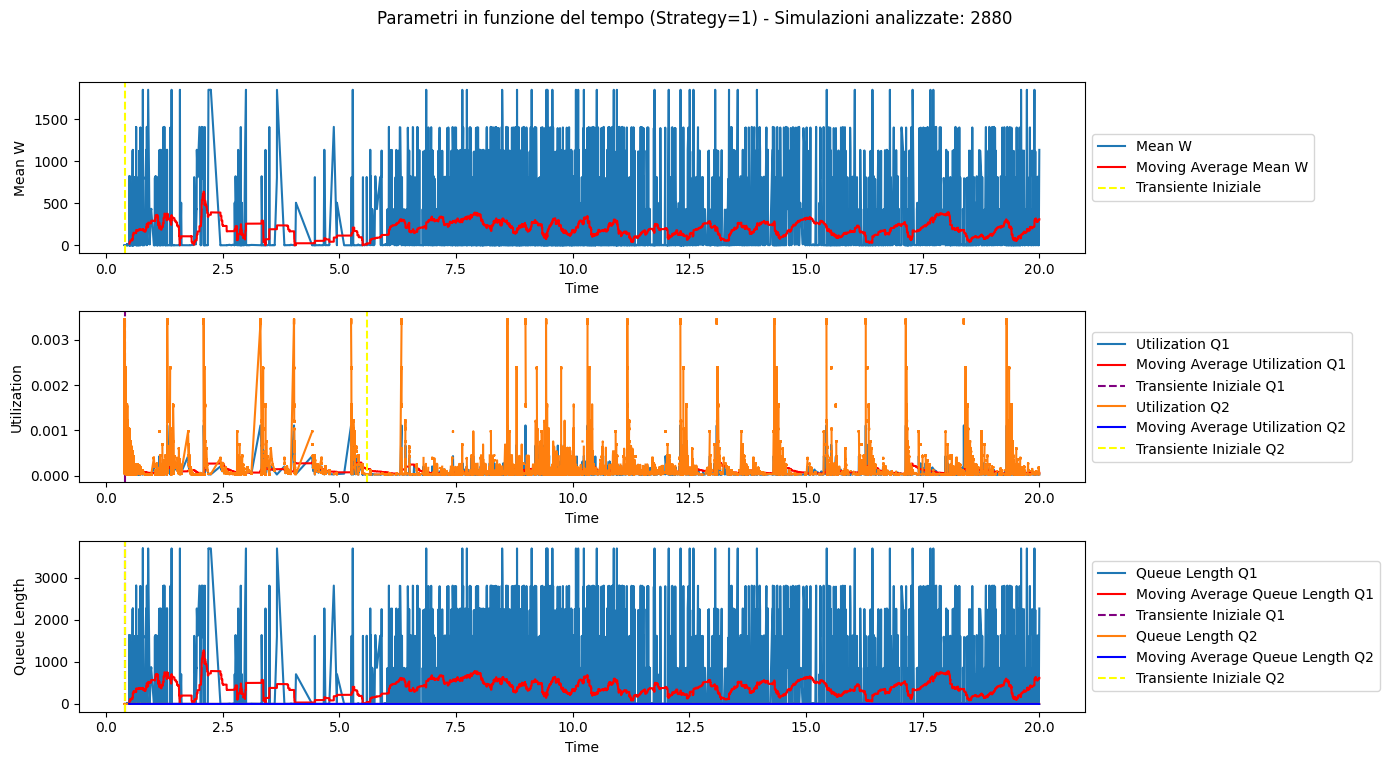

Transiente iniziale per mean_W (lambda=1.0): 0.41954058057
Transiente iniziale per utilization_Q1 (lambda=1.0): 0.41954058057
Transiente iniziale per utilization_Q2 (lambda=1.0): 1.269638585749
Transiente iniziale per queue_length_Q1 (lambda=1.0): 0.41954058057
Transiente iniziale per queue_length_Q2 (lambda=1.0): 0.41954058057
Media dei transienti iniziali (lambda=1.0): 0.5895601816058


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


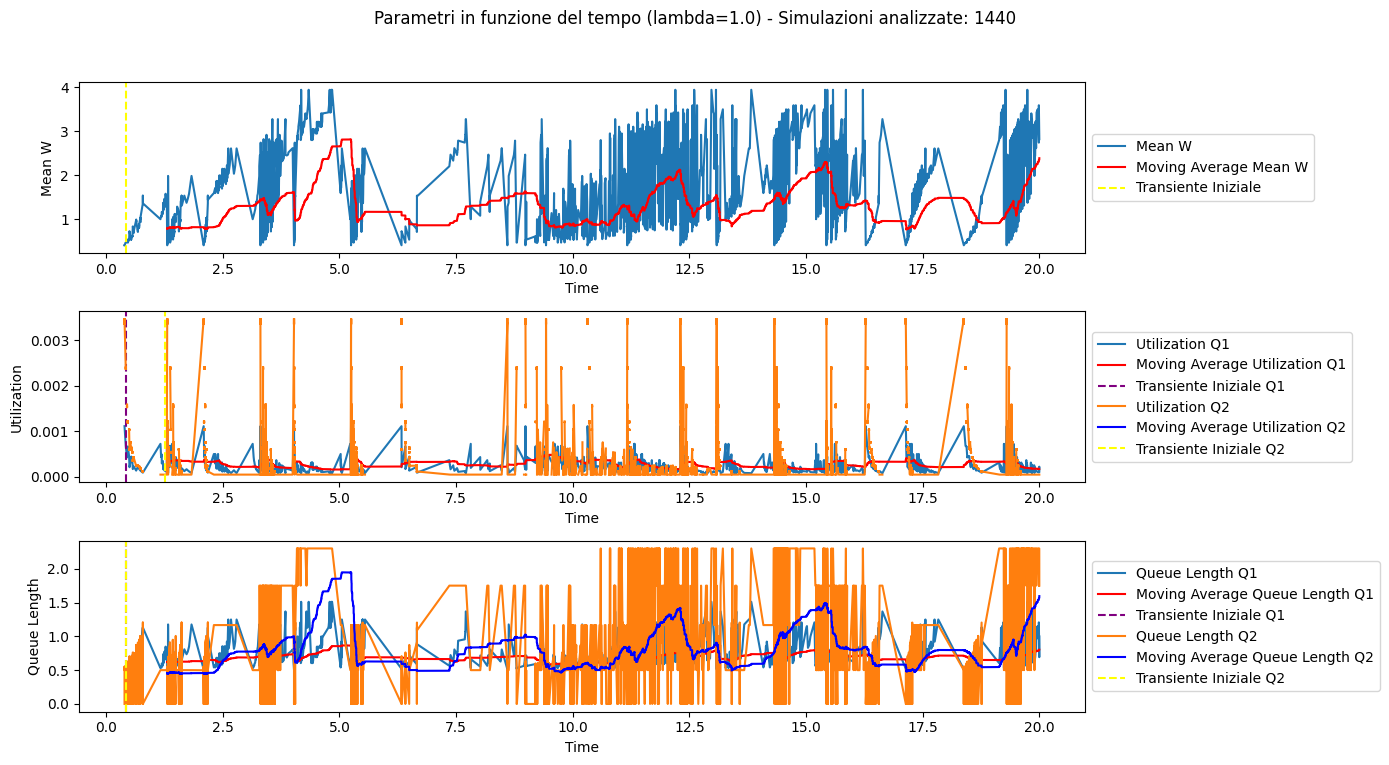

Transiente iniziale per mean_W (lambda=1.2): 0.41954058057
Transiente iniziale per utilization_Q1 (lambda=1.2): 0.41954058057
Transiente iniziale per utilization_Q2 (lambda=1.2): 1.079849560606
Transiente iniziale per queue_length_Q1 (lambda=1.2): 0.41954058057
Transiente iniziale per queue_length_Q2 (lambda=1.2): 0.41954058057
Media dei transienti iniziali (lambda=1.2): 0.5516023765772


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


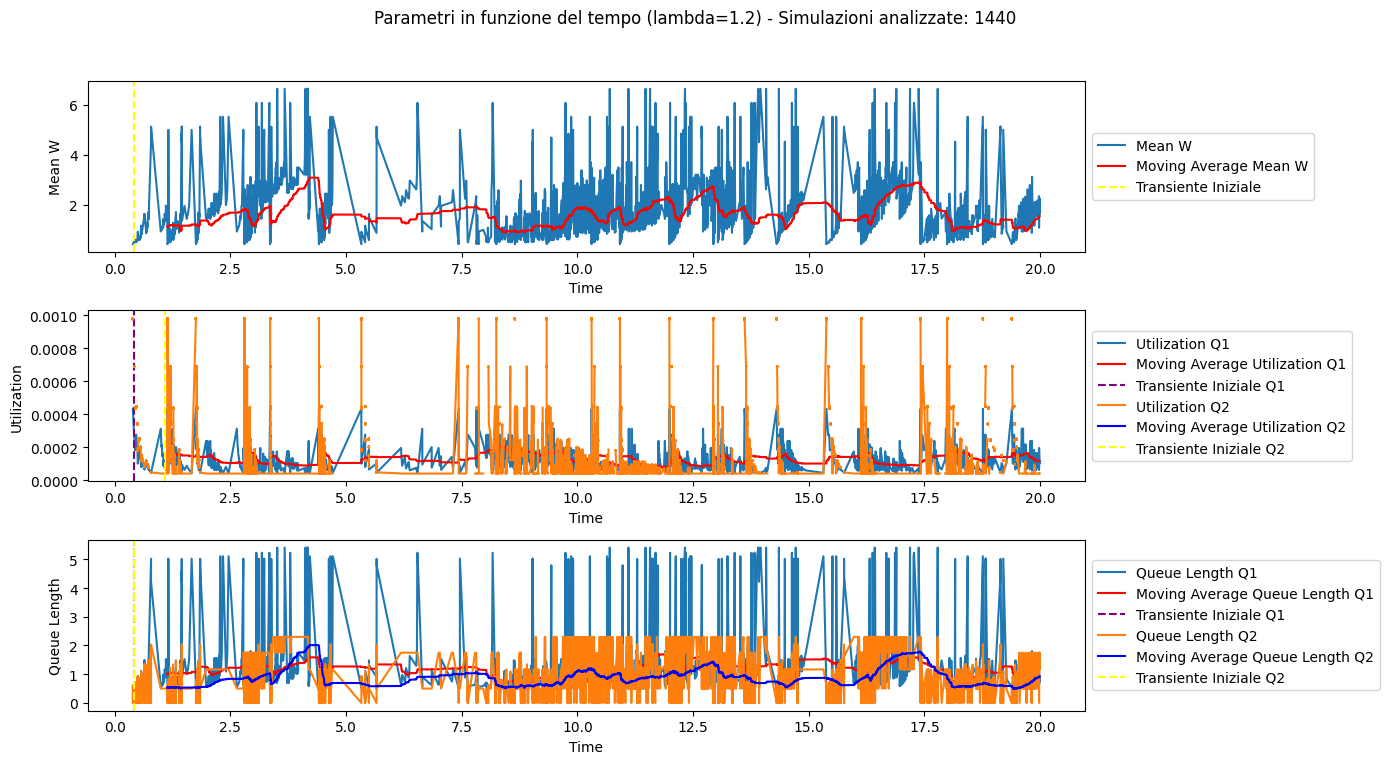

Transiente iniziale per mean_W (lambda=1.4): 0.41954058057
Transiente iniziale per utilization_Q1 (lambda=1.4): 0.41954058057
Transiente iniziale per utilization_Q2 (lambda=1.4): 0.983924300035
Transiente iniziale per queue_length_Q1 (lambda=1.4): 0.41954058057
Transiente iniziale per queue_length_Q2 (lambda=1.4): 0.41954058057
Media dei transienti iniziali (lambda=1.4): 0.5324173244629999


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


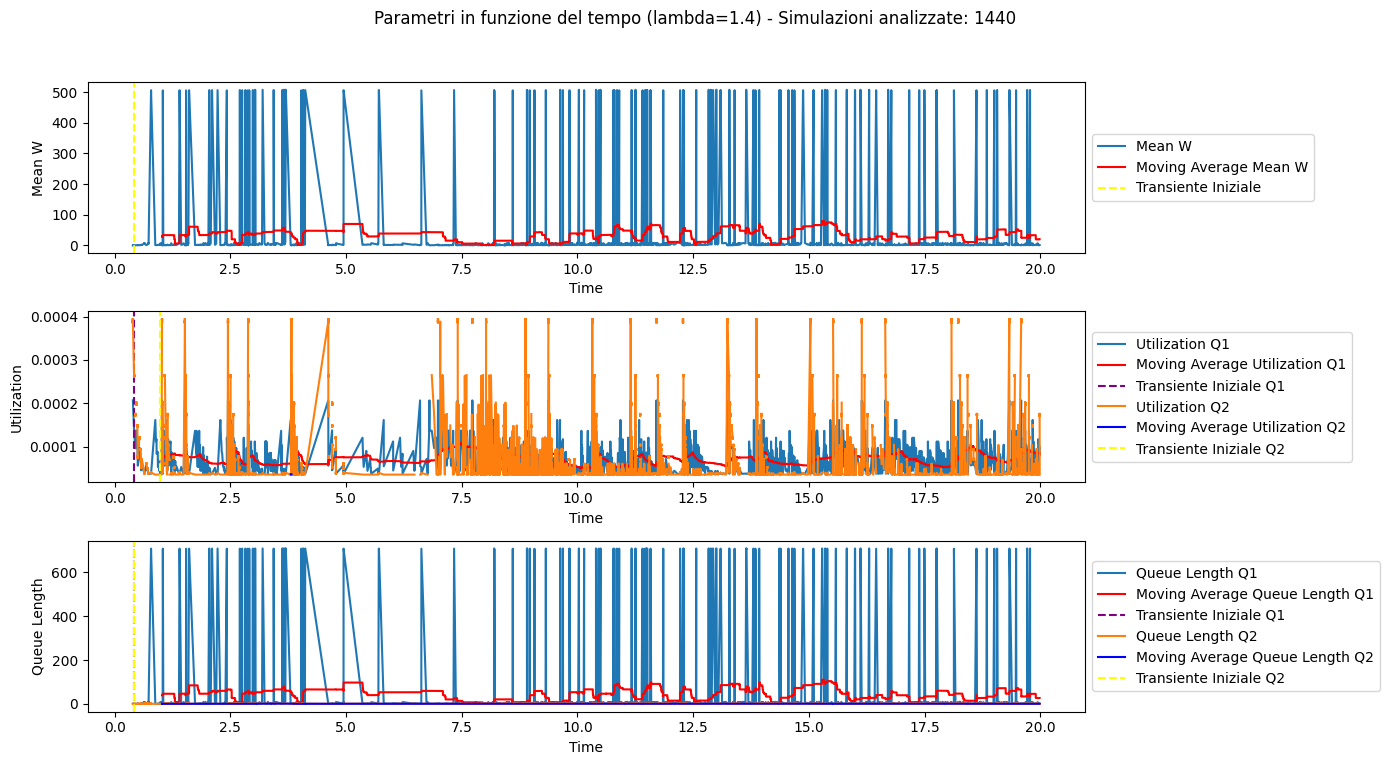

Transiente iniziale per mean_W (lambda=2.0): 0.41954058057
Transiente iniziale per utilization_Q1 (lambda=2.0): 0.41954058057
Transiente iniziale per utilization_Q2 (lambda=2.0): 1.366083312268
Transiente iniziale per queue_length_Q1 (lambda=2.0): 0.41954058057
Transiente iniziale per queue_length_Q2 (lambda=2.0): 0.41954058057
Media dei transienti iniziali (lambda=2.0): 0.6088491269096


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


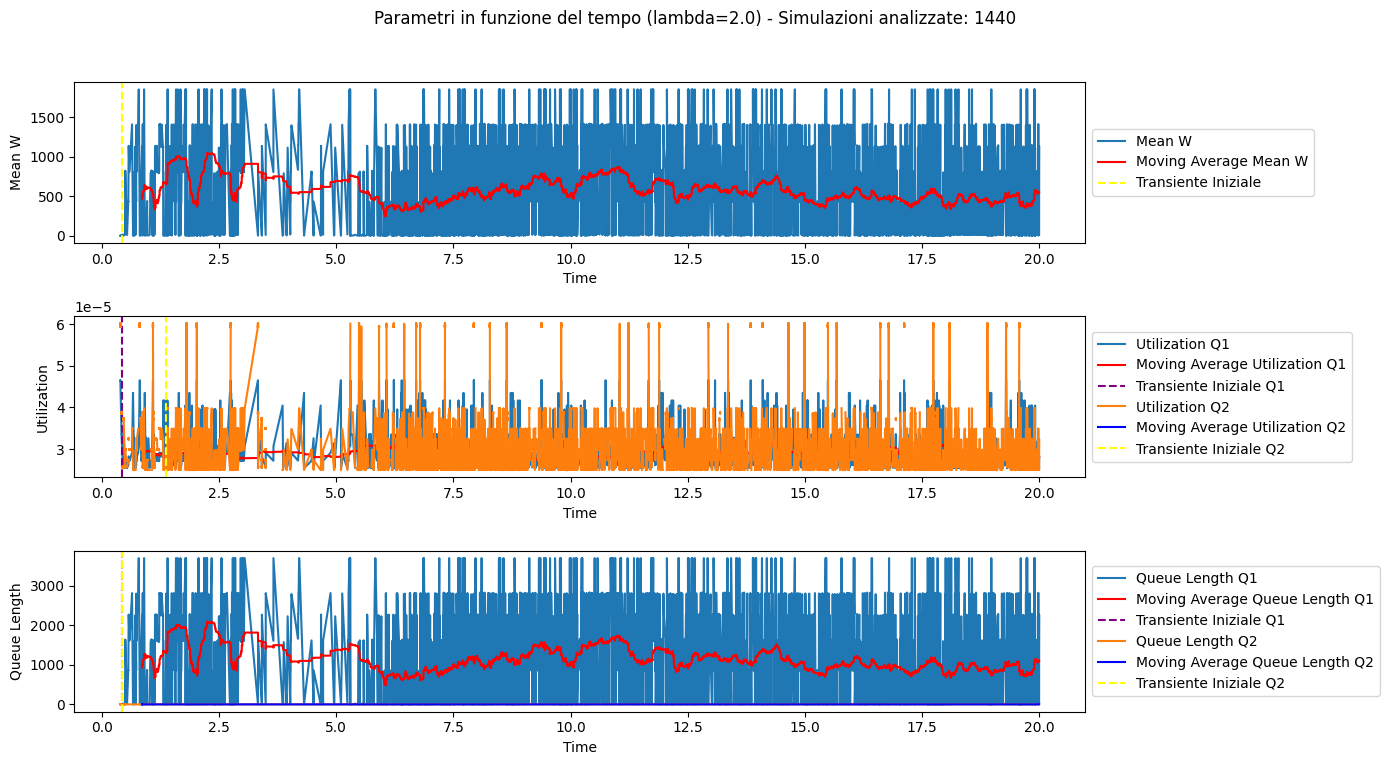

Transiente iniziale per mean_W (m1=0.2): 0.392925949277
Transiente iniziale per utilization_Q1 (m1=0.2): 0.392925949277
Transiente iniziale per utilization_Q2 (m1=0.2): 1.735615875847
Transiente iniziale per queue_length_Q1 (m1=0.2): 0.392925949277
Transiente iniziale per queue_length_Q2 (m1=0.2): 0.392925949277
Media dei transienti iniziali (m1=0.2): 0.661463934591


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


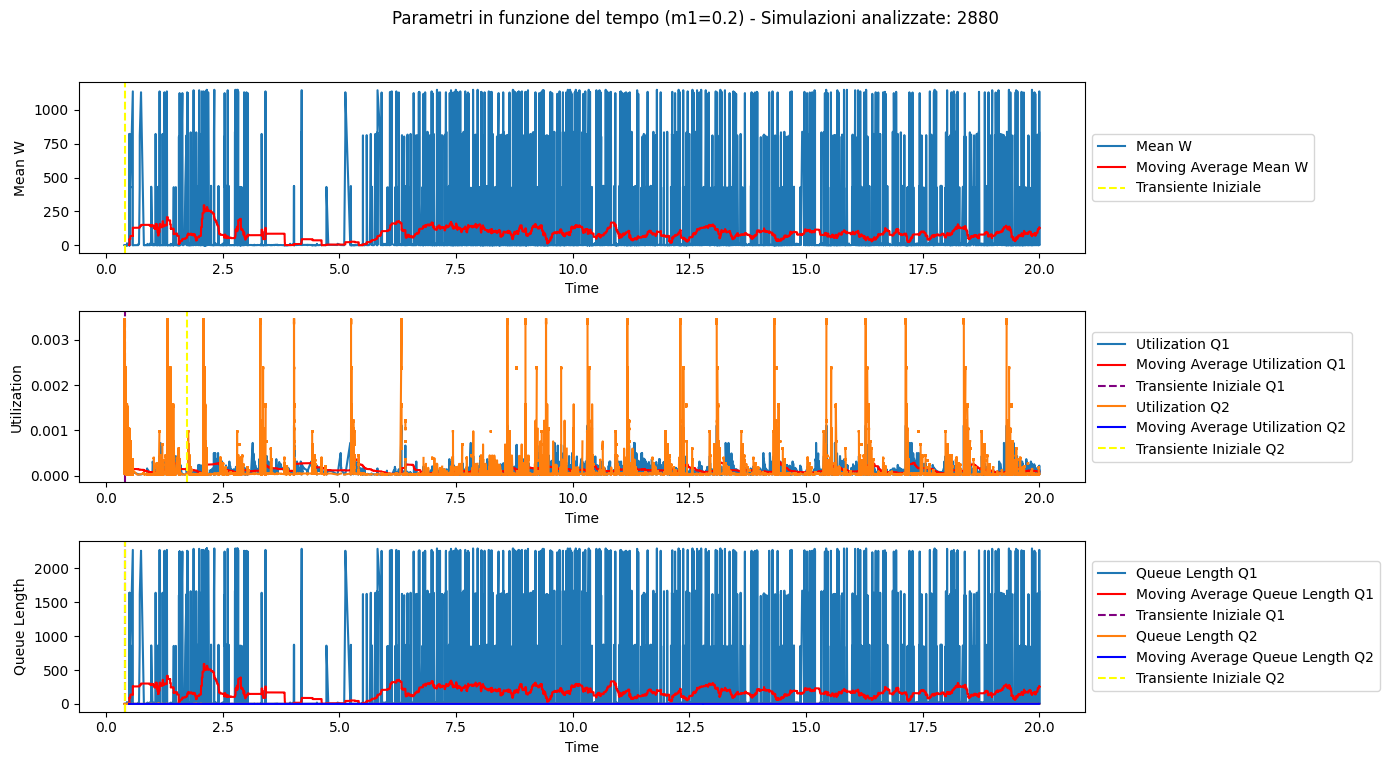

Transiente iniziale per mean_W (m1=0.25): 0.464542805303
Transiente iniziale per utilization_Q1 (m1=0.25): 0.464542805303
Transiente iniziale per utilization_Q2 (m1=0.25): 2.299570604246
Transiente iniziale per queue_length_Q1 (m1=0.25): 0.464542805303
Transiente iniziale per queue_length_Q2 (m1=0.25): 0.464542805303
Media dei transienti iniziali (m1=0.25): 0.8315483650916


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


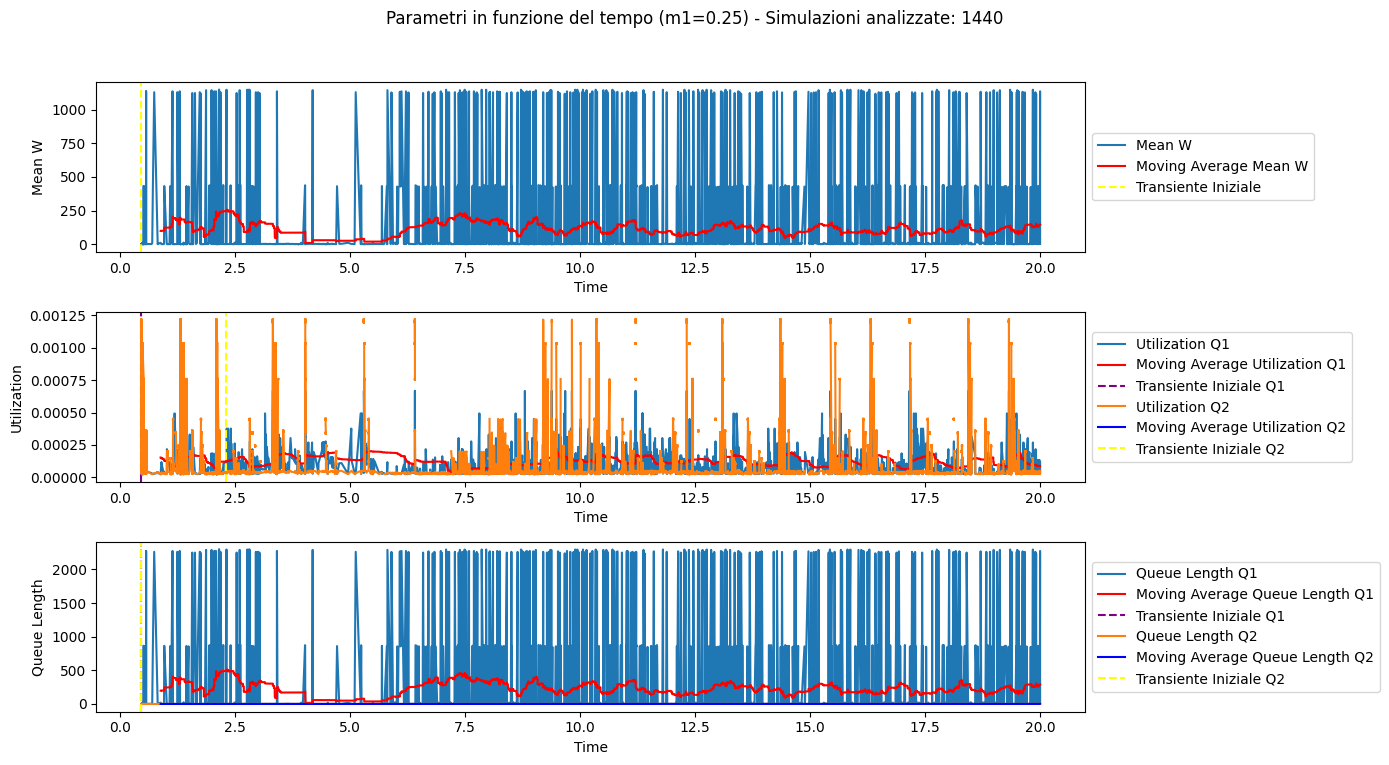

Transiente iniziale per mean_W (m1=0.3): 0.536159661329
Transiente iniziale per utilization_Q1 (m1=0.3): 0.536159661329
Transiente iniziale per utilization_Q2 (m1=0.3): 2.312857286858
Transiente iniziale per queue_length_Q1 (m1=0.3): 0.536159661329
Transiente iniziale per queue_length_Q2 (m1=0.3): 0.536159661329
Media dei transienti iniziali (m1=0.3): 0.8914991864348


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


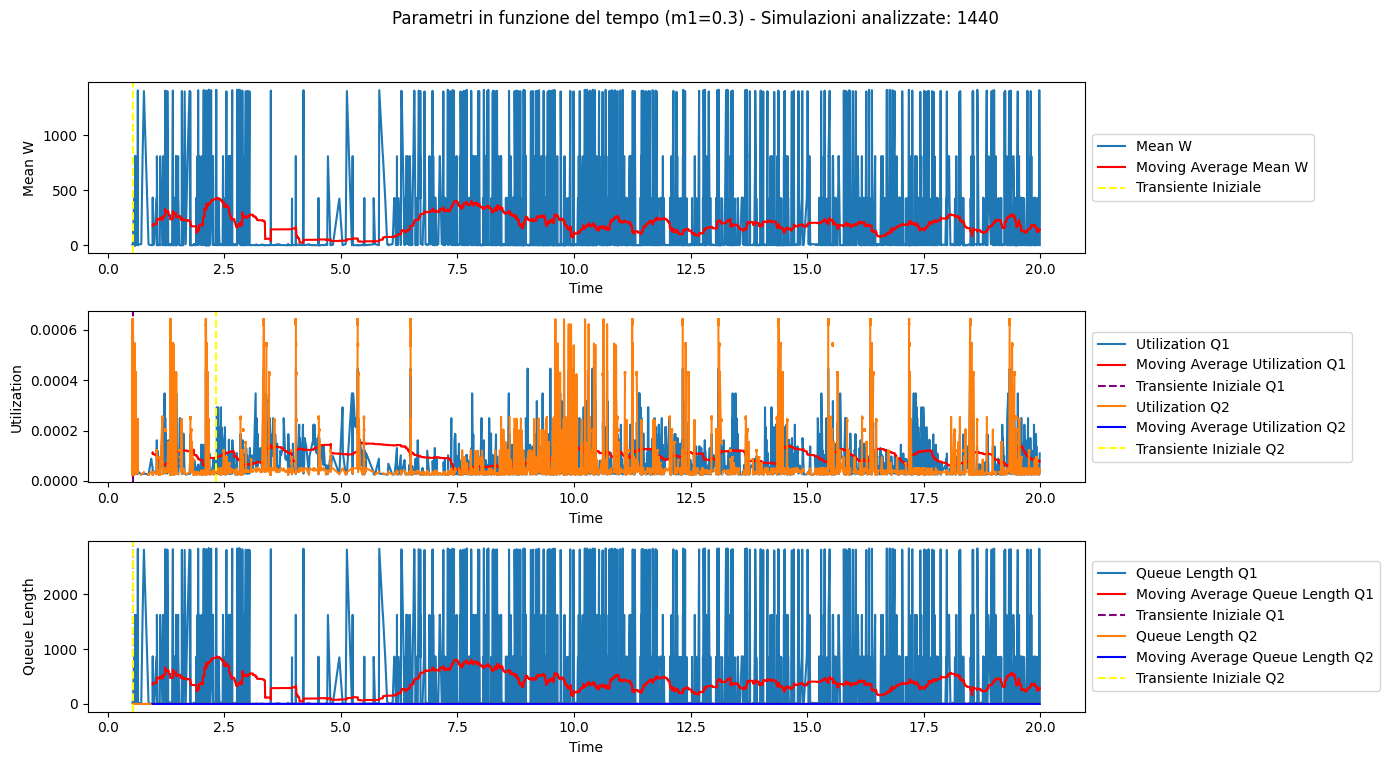

Transiente iniziale per mean_W (m1=0.4): 0.679393373381
Transiente iniziale per utilization_Q1 (m1=0.4): 0.679393373381
Transiente iniziale per utilization_Q2 (m1=0.4): 0.870934201658
Transiente iniziale per queue_length_Q1 (m1=0.4): 0.679393373381
Transiente iniziale per queue_length_Q2 (m1=0.4): 0.679393373381
Media dei transienti iniziali (m1=0.4): 0.7177015390364


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


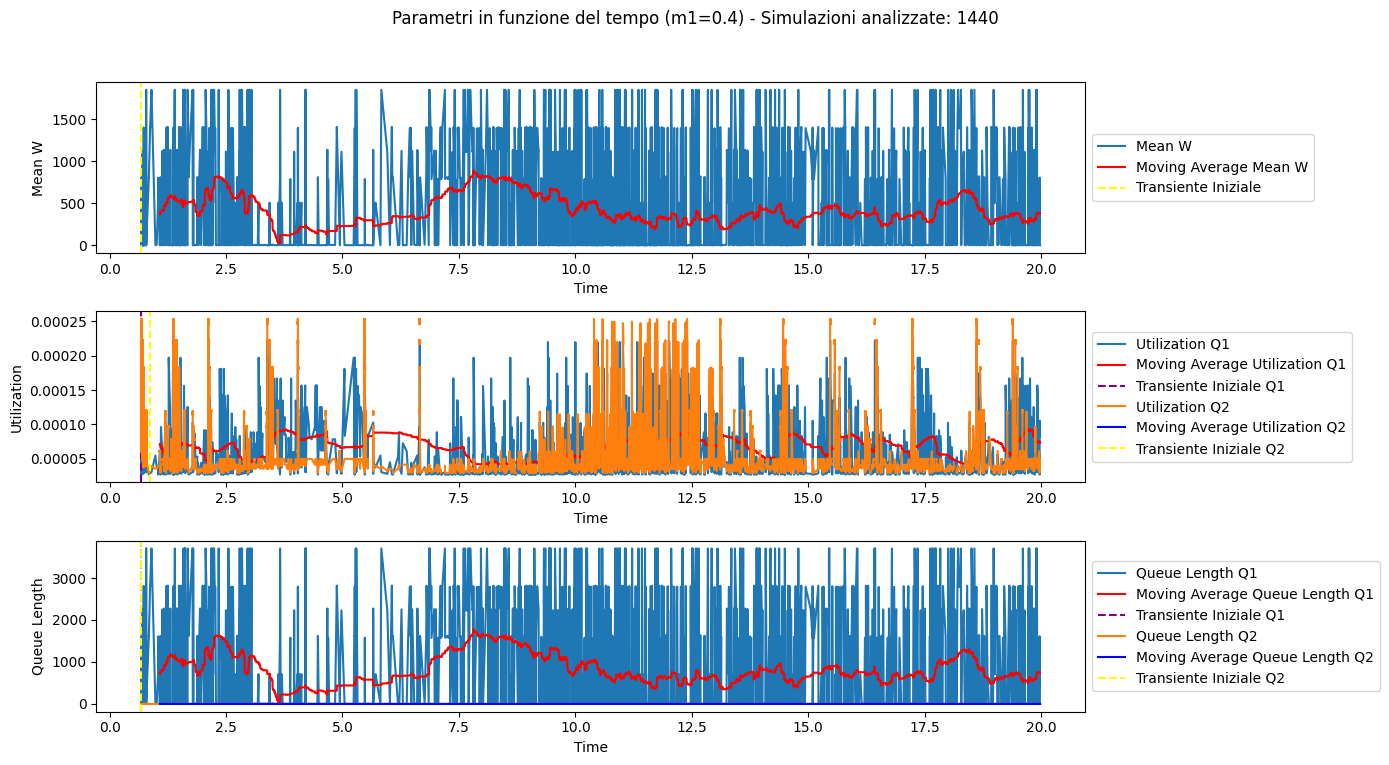

Transiente iniziale per mean_W (m2=0.2): 0.392925949277
Transiente iniziale per utilization_Q1 (m2=0.2): 0.392925949277
Transiente iniziale per utilization_Q2 (m2=0.2): 1.750743798418
Transiente iniziale per queue_length_Q1 (m2=0.2): 0.392925949277
Transiente iniziale per queue_length_Q2 (m2=0.2): 0.392925949277
Media dei transienti iniziali (m2=0.2): 0.6644895191052


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


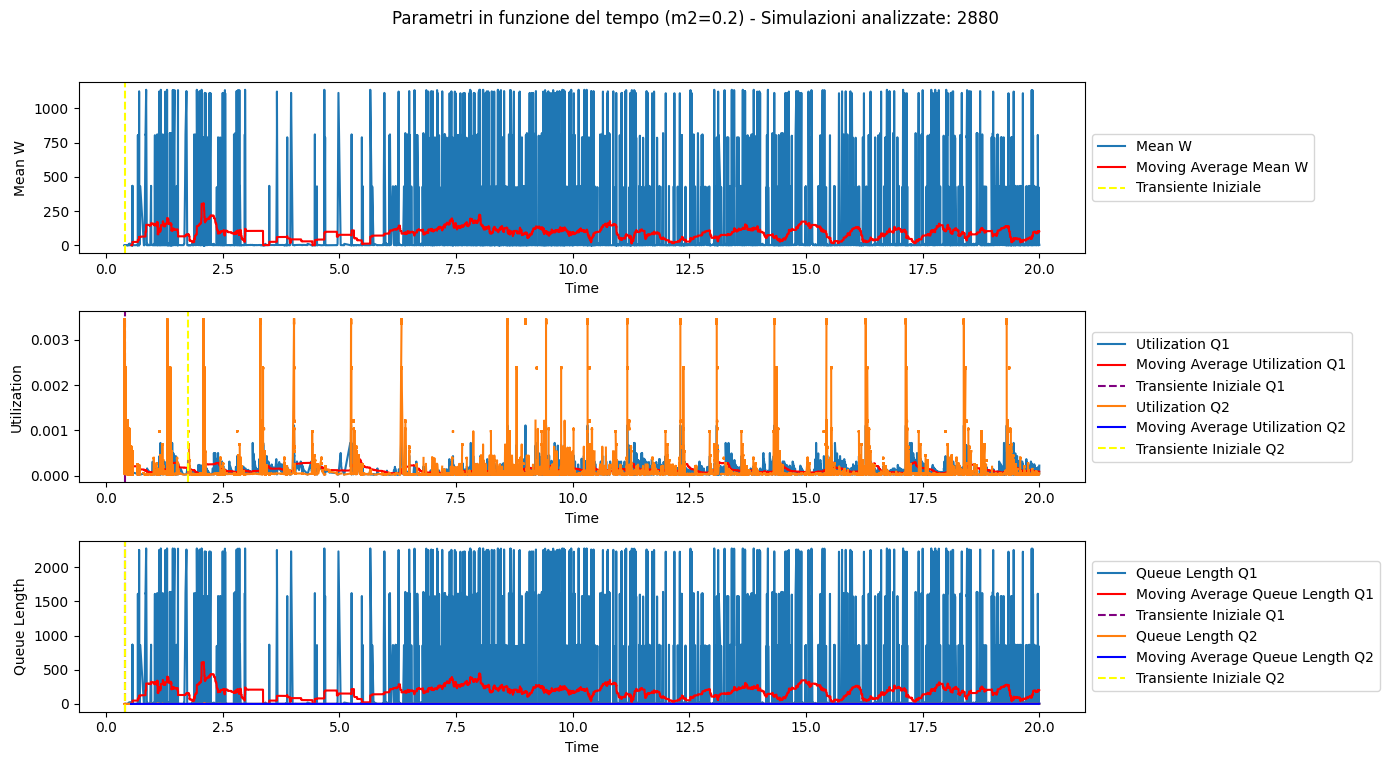

Transiente iniziale per mean_W (m2=0.25): 0.41954058057
Transiente iniziale per utilization_Q1 (m2=0.25): 0.41954058057
Transiente iniziale per utilization_Q2 (m2=0.25): 2.245123350072
Transiente iniziale per queue_length_Q1 (m2=0.25): 0.41954058057
Transiente iniziale per queue_length_Q2 (m2=0.25): 0.41954058057
Media dei transienti iniziali (m2=0.25): 0.7846571344704


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


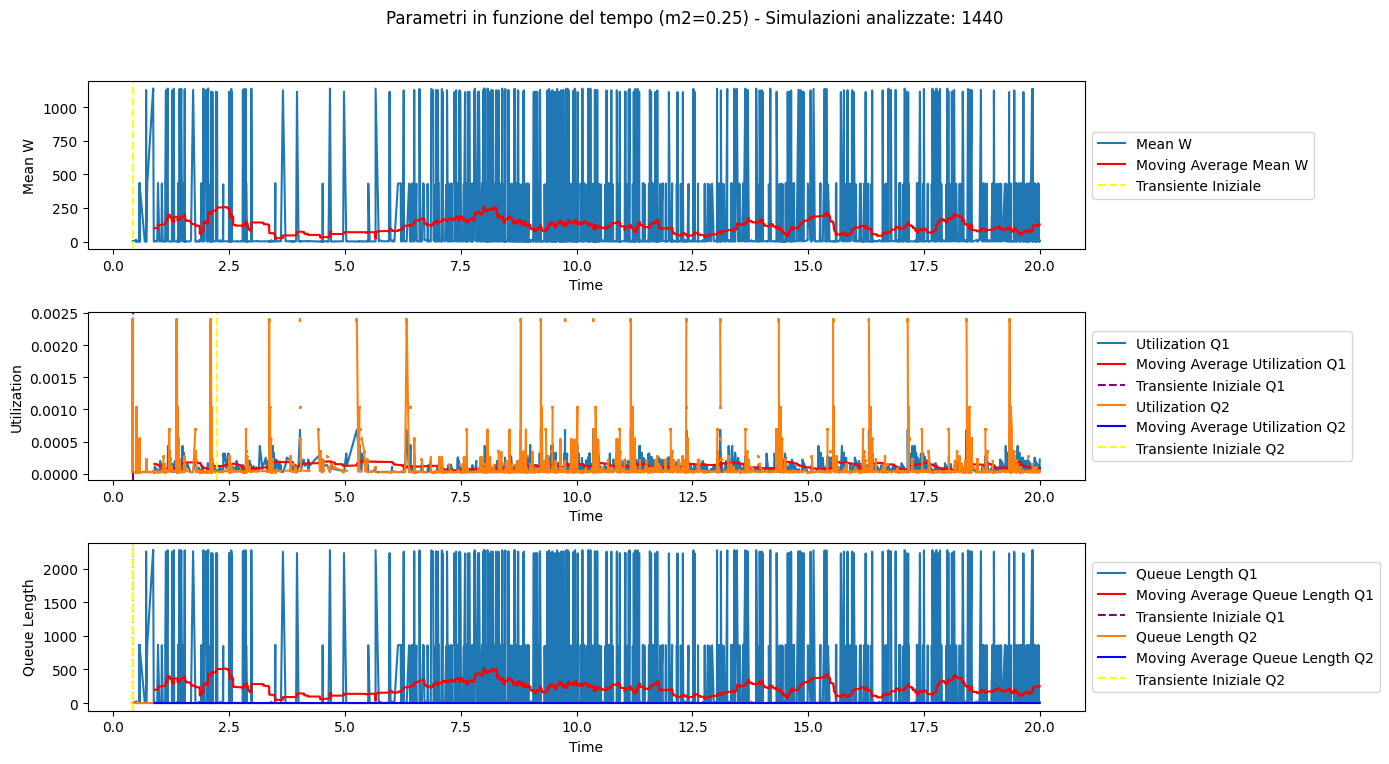

Transiente iniziale per mean_W (m2=0.3): 0.446155211863
Transiente iniziale per utilization_Q1 (m2=0.3): 0.446155211863
Transiente iniziale per utilization_Q2 (m2=0.3): 2.262722836789
Transiente iniziale per queue_length_Q1 (m2=0.3): 0.446155211863
Transiente iniziale per queue_length_Q2 (m2=0.3): 0.446155211863
Media dei transienti iniziali (m2=0.3): 0.8094687368482001


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


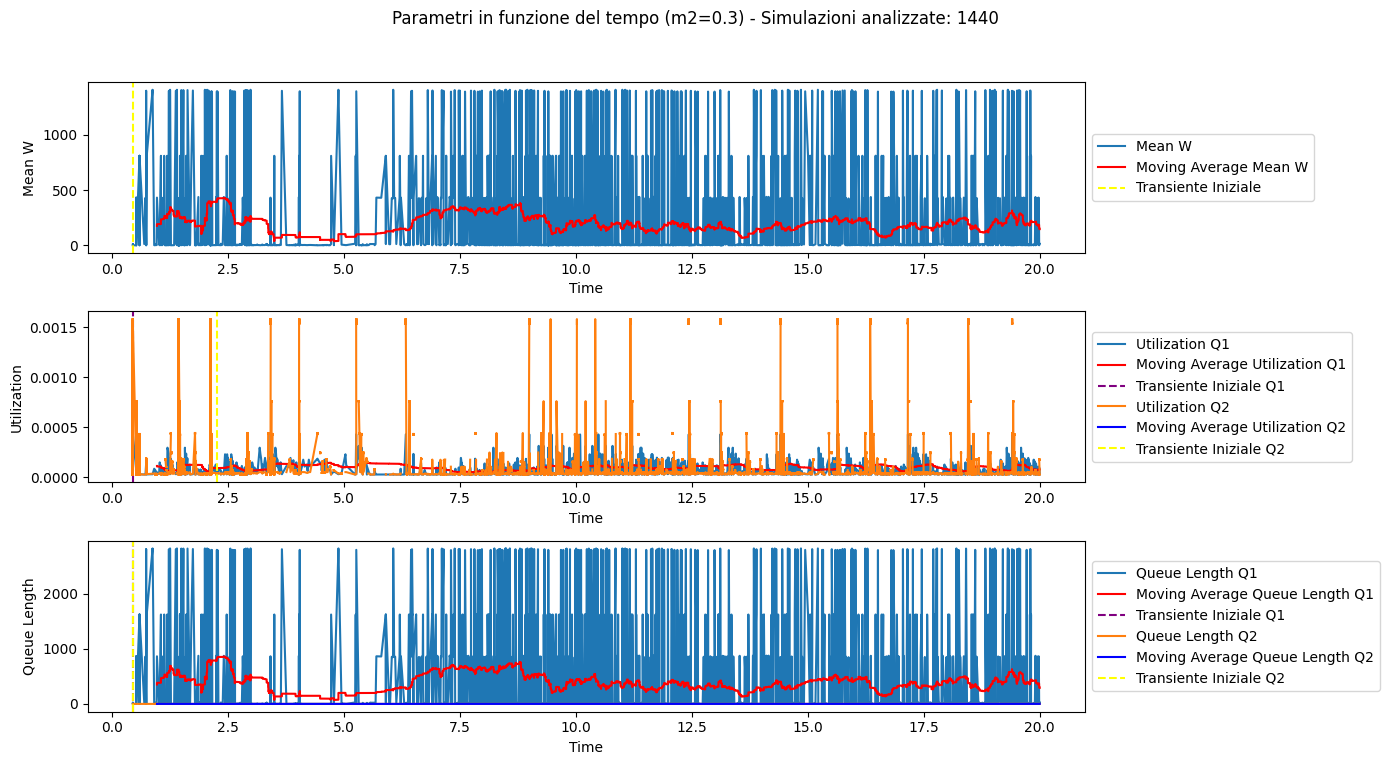

Transiente iniziale per mean_W (m2=0.4): 0.499384474449
Transiente iniziale per utilization_Q1 (m2=0.4): 0.499384474449
Transiente iniziale per utilization_Q2 (m2=0.4): 1.750527934726
Transiente iniziale per queue_length_Q1 (m2=0.4): 0.499384474449
Transiente iniziale per queue_length_Q2 (m2=0.4): 0.499384474449
Media dei transienti iniziali (m2=0.4): 0.7496131665044


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


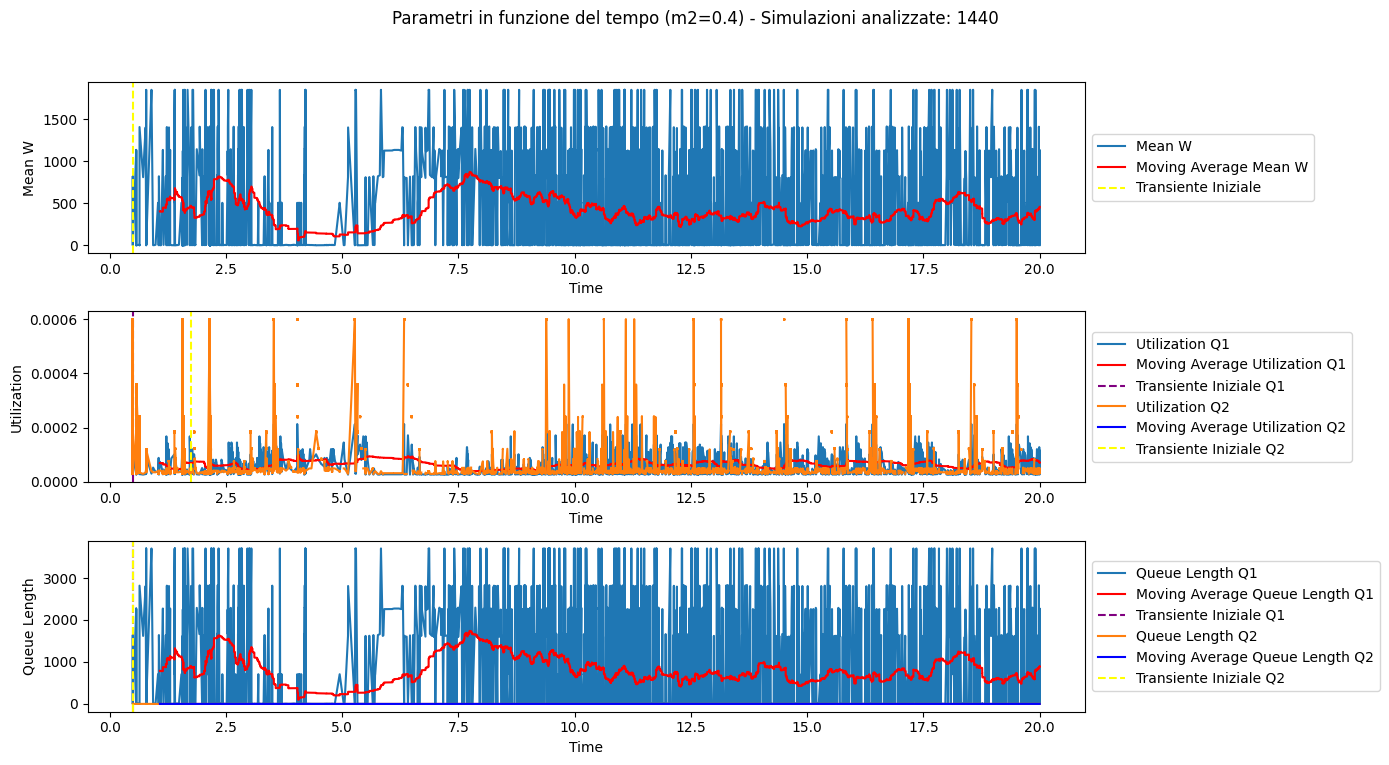

Transiente iniziale per mean_W (N=1): 0.41954058057
Transiente iniziale per utilization_Q1 (N=1): 0.41954058057
Transiente iniziale per queue_length_Q1 (N=1): 0.41954058057
Transiente iniziale per queue_length_Q2 (N=1): 0.41954058057
Media dei transienti iniziali (N=1): 0.41954058057


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


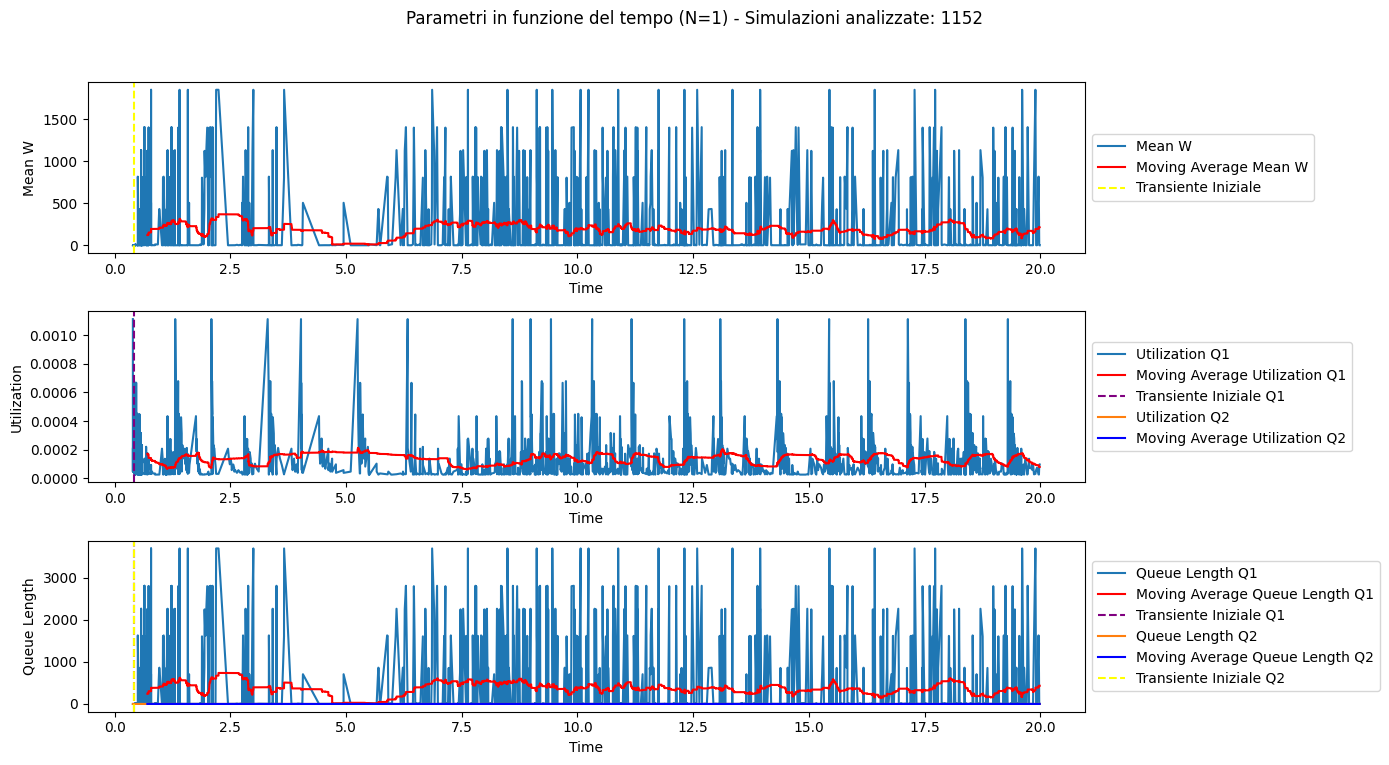

Transiente iniziale per mean_W (N=2): 0.446155211863
Transiente iniziale per utilization_Q1 (N=2): 0.446155211863
Transiente iniziale per utilization_Q2 (N=2): 0.446155211863
Transiente iniziale per queue_length_Q1 (N=2): 0.446155211863
Transiente iniziale per queue_length_Q2 (N=2): 0.446155211863
Media dei transienti iniziali (N=2): 0.446155211863


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


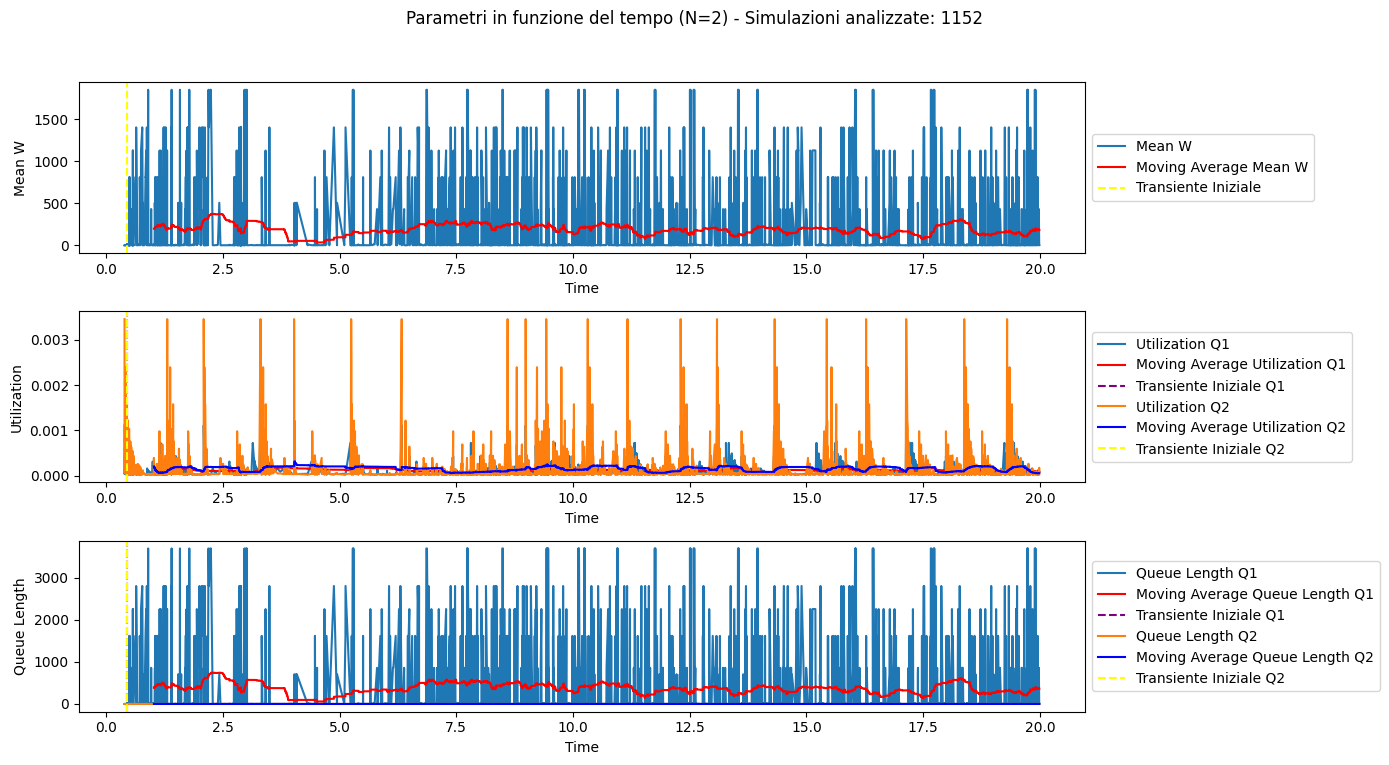

Transiente iniziale per mean_W (N=3): 0.446155211863
Transiente iniziale per utilization_Q1 (N=3): 0.446155211863
Transiente iniziale per utilization_Q2 (N=3): 0.446155211863
Transiente iniziale per queue_length_Q1 (N=3): 0.446155211863
Transiente iniziale per queue_length_Q2 (N=3): 0.446155211863
Media dei transienti iniziali (N=3): 0.446155211863


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


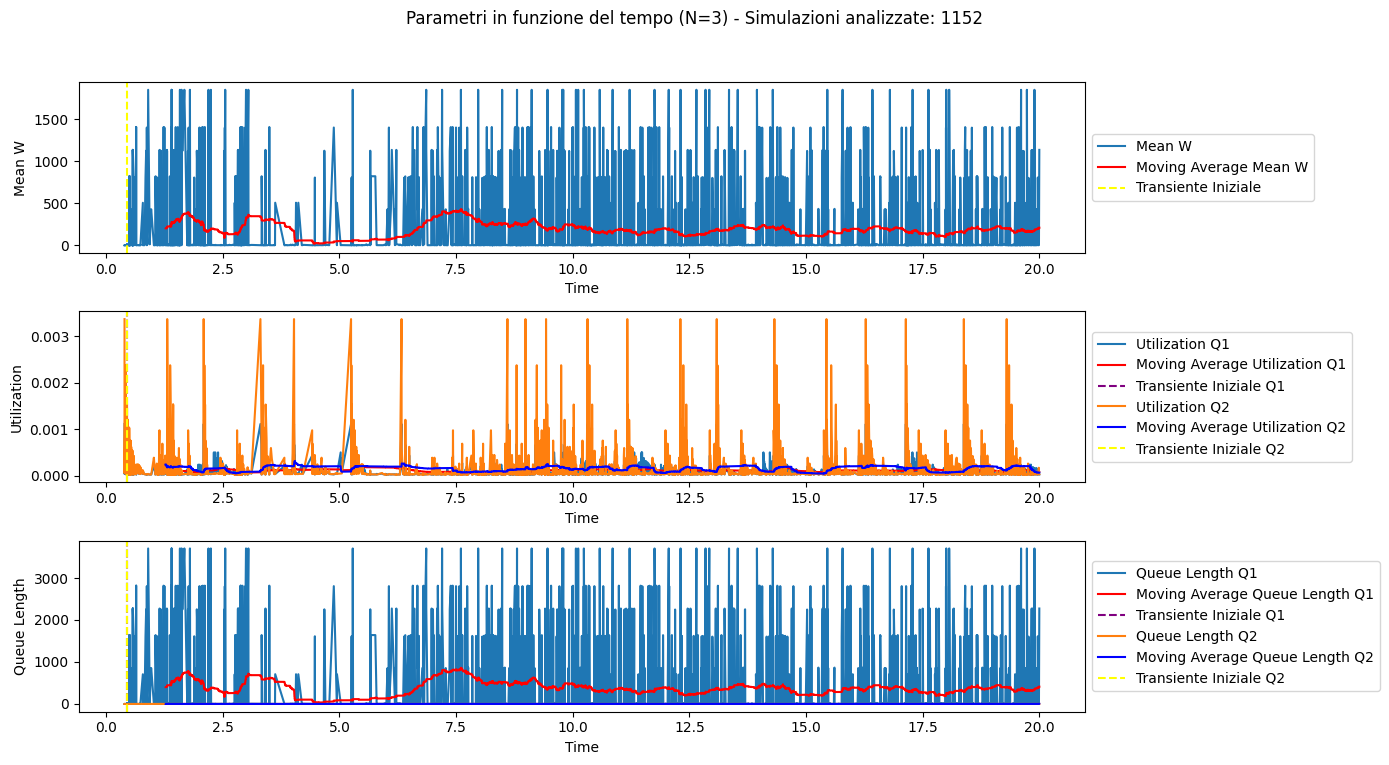

Transiente iniziale per mean_W (N=4): 0.446155211863
Transiente iniziale per utilization_Q1 (N=4): 0.446155211863
Transiente iniziale per utilization_Q2 (N=4): 0.446155211863
Transiente iniziale per queue_length_Q1 (N=4): 0.446155211863
Transiente iniziale per queue_length_Q2 (N=4): 0.446155211863
Media dei transienti iniziali (N=4): 0.446155211863


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


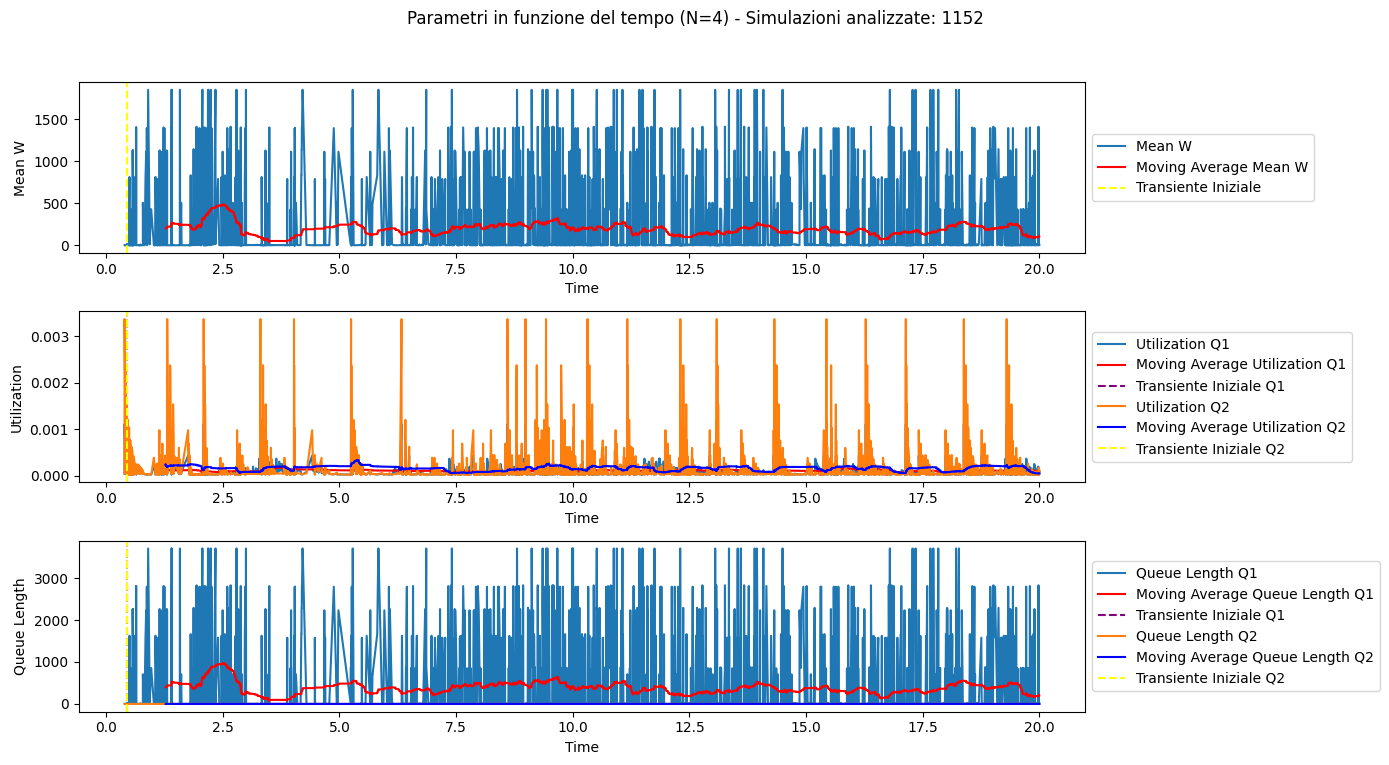

Transiente iniziale per mean_W (N=5): 0.446155211863
Transiente iniziale per utilization_Q1 (N=5): 0.446155211863
Transiente iniziale per utilization_Q2 (N=5): 0.446155211863
Transiente iniziale per queue_length_Q1 (N=5): 0.446155211863
Transiente iniziale per queue_length_Q2 (N=5): 0.446155211863
Media dei transienti iniziali (N=5): 0.446155211863


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


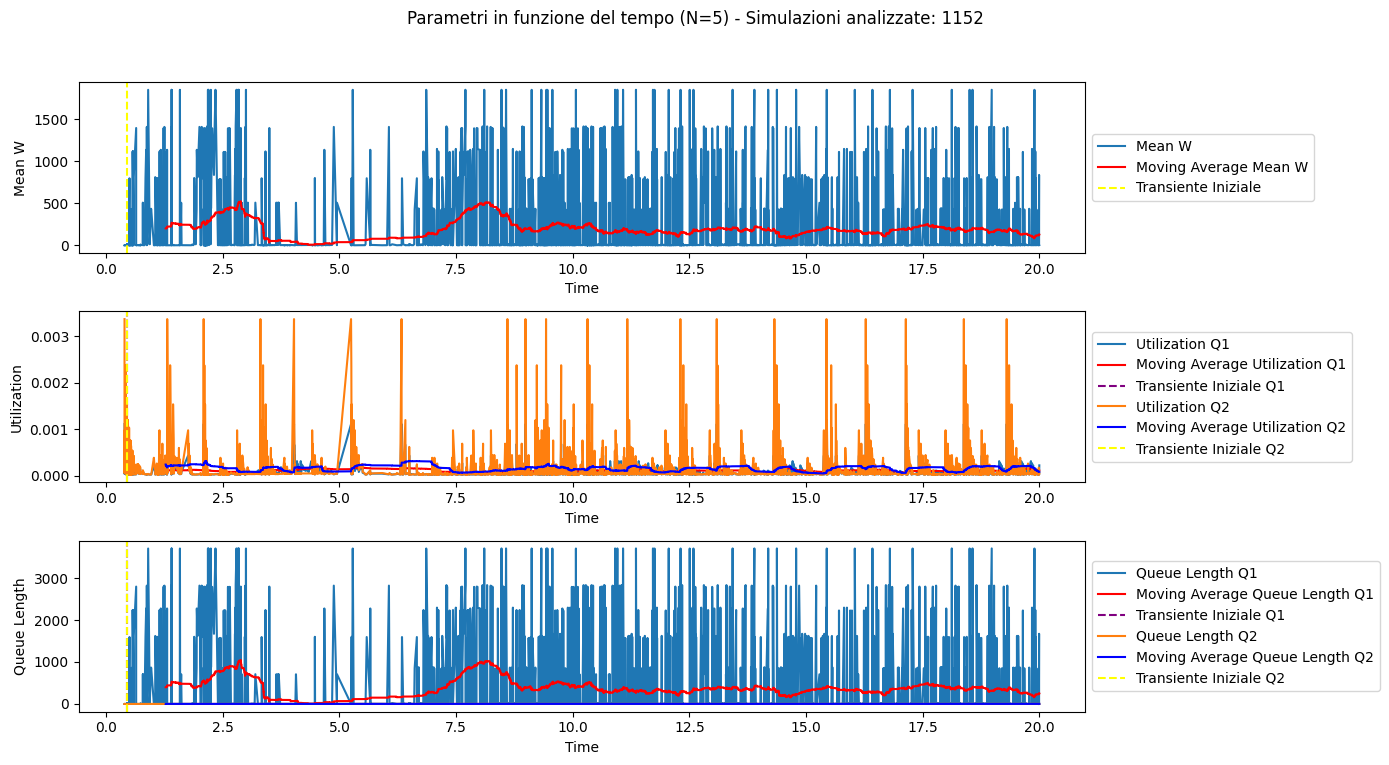

Media dei transienti iniziali per Strategy=0: 0.6919681760508001
Media dei transienti iniziali per Strategy=1: 1.4310262558258002
Media dei transienti iniziali per lambda=1.0: 0.5895601816058
Media dei transienti iniziali per lambda=1.2: 0.5516023765772
Media dei transienti iniziali per lambda=1.4: 0.5324173244629999
Media dei transienti iniziali per lambda=2.0: 0.6088491269096
Media dei transienti iniziali per m1=0.2: 0.661463934591
Media dei transienti iniziali per m1=0.25: 0.8315483650916
Media dei transienti iniziali per m1=0.3: 0.8914991864348
Media dei transienti iniziali per m1=0.4: 0.7177015390364
Media dei transienti iniziali per m2=0.2: 0.6644895191052
Media dei transienti iniziali per m2=0.25: 0.7846571344704
Media dei transienti iniziali per m2=0.3: 0.8094687368482001
Media dei transienti iniziali per m2=0.4: 0.7496131665044
Media dei transienti iniziali per N=1: 0.41954058057
Media dei transienti iniziali per N=2: 0.446155211863
Media dei transienti iniziali per N=3: 0.446

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che il tuo dataframe si chiami 'results_df'
# Creiamo un dataframe dai dati forniti
results_df = pd.read_csv('./results_summary.csv')

# Convertiamo le colonne lifeTime e lifeTime_arrival da stringhe a liste di numeri
results_df['lifeTime'] = results_df['lifeTime'].apply(lambda x: list(map(float, x.split(','))))
results_df['lifeTime_arrival'] = results_df['lifeTime_arrival'].apply(lambda x: list(map(float, x.split(','))))

# Filtri aggiuntivi
parameters = [
    'Strategy=0', 'Strategy=1', 'lambda=1.0', 'lambda=1.2', 'lambda=1.4', 'lambda=2.0', 'm1=0.2', 'm1=0.25', 'm1=0.3', 'm1=0.4', 'm2=0.2', 'm2=0.25', 'm2=0.3', 'm2=0.4', 'N=1', 'N=2', 'N=3', 'N=4', 'N=5'
]

# Funzione per creare e visualizzare i plot per una determinata strategia o parametro
def plot_strategy(dataframe, label, window_size=1000, time_limit=20):
    # Ridurre il campione di dati analizzati
    sample_size = int(len(dataframe) * 1)
    sampled_df = dataframe.head(sample_size)
    
    # Creazione del DataFrame per i job completati in base al tempo di arrivo
    arrival_times = []
    mean_W_values = []
    utilization_Q1_values = []
    utilization_Q2_values = []
    queue_length_Q1_values = []
    queue_length_Q2_values = []

    for index, row in sampled_df.iterrows():
        arrival_times.extend(row['lifeTime_arrival'])
        mean_W_values.extend([row['mean_W']] * len(row['lifeTime_arrival']))
        utilization_Q1_values.extend([row['mean_utilization_Q1']] * len(row['lifeTime_arrival']))
        utilization_Q2_values.extend([row['mean_utilization_Q2']] * len(row['lifeTime_arrival']))
        queue_length_Q1_values.extend([row['mean_queueLength_Q1']] * len(row['lifeTime_arrival']))
        queue_length_Q2_values.extend([row['mean_queueLength_Q2']] * len(row['lifeTime_arrival']))

    # Creiamo un DataFrame per facilitare le operazioni
    time_df = pd.DataFrame({
        'arrival_time': arrival_times,
        'mean_W': mean_W_values,
        'utilization_Q1': utilization_Q1_values,
        'utilization_Q2': utilization_Q2_values,
        'queue_length_Q1': queue_length_Q1_values,
        'queue_length_Q2': queue_length_Q2_values
    })

    # Filtrare il DataFrame fino al tempo limite
    time_df = time_df[time_df['arrival_time'] <= time_limit]

    # Ordiniamo per tempo di arrivo
    time_df = time_df.sort_values(by='arrival_time').reset_index(drop=True)

    # Calcolo della media mobile per i parametri in funzione del tempo
    time_df['mean_W_moving_avg'] = time_df['mean_W'].rolling(window=window_size).mean()
    time_df['utilization_Q1_moving_avg'] = time_df['utilization_Q1'].rolling(window=window_size).mean()
    if 'utilization_Q2' in time_df:
        time_df['utilization_Q2_moving_avg'] = time_df['utilization_Q2'].rolling(window=window_size).mean()
    time_df['queue_length_Q1_moving_avg'] = time_df['queue_length_Q1'].rolling(window=window_size).mean()
    if 'queue_length_Q2' in time_df:
        time_df['queue_length_Q2_moving_avg'] = time_df['queue_length_Q2'].rolling(window=window_size).mean()

    # Metodo per calcolare il transiente iniziale basato sulla stabilizzazione della media mobile in funzione del tempo
    def calculate_transient_initial(time_series, value_series, window_size=100, threshold=0.01):
        moving_avg = value_series.rolling(window=window_size).mean()
        stabilization_point = None

        for i in range(window_size, len(moving_avg)):
            if np.abs(moving_avg[i] - moving_avg[i-1]) < threshold:
                stabilization_point = i
                break

        if stabilization_point is not None:
            return time_series[stabilization_point]
        else:
            return None

    # Calcoliamo il transiente iniziale per i parametri in funzione del tempo
    transient_initial_mean_W = calculate_transient_initial(time_df['arrival_time'], time_df['mean_W'])
    transient_initial_utilization_Q1 = calculate_transient_initial(time_df['arrival_time'], time_df['utilization_Q1'])
    transient_initial_queue_length_Q1 = calculate_transient_initial(time_df['arrival_time'], time_df['queue_length_Q1'])
    
    if 'utilization_Q2' in time_df:
        transient_initial_utilization_Q2 = calculate_transient_initial(time_df['arrival_time'], time_df['utilization_Q2'])
    else:
        transient_initial_utilization_Q2 = None

    if 'queue_length_Q2' in time_df:
        transient_initial_queue_length_Q2 = calculate_transient_initial(time_df['arrival_time'], time_df['queue_length_Q2'])
    else:
        transient_initial_queue_length_Q2 = None

    print(f'Transiente iniziale per mean_W ({label}): {transient_initial_mean_W}')
    print(f'Transiente iniziale per utilization_Q1 ({label}): {transient_initial_utilization_Q1}')
    if transient_initial_utilization_Q2 is not None:
        print(f'Transiente iniziale per utilization_Q2 ({label}): {transient_initial_utilization_Q2}')
    print(f'Transiente iniziale per queue_length_Q1 ({label}): {transient_initial_queue_length_Q1}')
    if transient_initial_queue_length_Q2 is not None:
        print(f'Transiente iniziale per queue_length_Q2 ({label}): {transient_initial_queue_length_Q2}')

    transient_values = [
        transient_initial_mean_W,
        transient_initial_utilization_Q1,
        transient_initial_utilization_Q2,
        transient_initial_queue_length_Q1,
        transient_initial_queue_length_Q2
    ]

    transient_values = [value for value in transient_values if value is not None]
    transient_average = np.mean(transient_values) if transient_values else None

    print(f'Media dei transienti iniziali ({label}): {transient_average}')

    # Numero di simulazioni analizzate
    num_simulations = len(sampled_df)

    # Grafico per visualizzare i parametri in funzione del tempo con il transiente iniziale annotato
    plt.figure(figsize=(14, 8))
    plt.suptitle(f'Parametri in funzione del tempo ({label}) - Simulazioni analizzate: {num_simulations}')
    
    plt.subplot(3, 1, 1)
    plt.plot(time_df['arrival_time'], time_df['mean_W'], label='Mean W')
    plt.plot(time_df['arrival_time'], time_df['mean_W_moving_avg'], label='Moving Average Mean W', color='red')
    if transient_initial_mean_W is not None:
        plt.axvline(x=transient_initial_mean_W, color='yellow', linestyle='--', label='Transiente Iniziale')
    plt.xlabel('Time')
    plt.ylabel('Mean W')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.subplot(3, 1, 2)
    plt.plot(time_df['arrival_time'], time_df['utilization_Q1'], label='Utilization Q1')
    plt.plot(time_df['arrival_time'], time_df['utilization_Q1_moving_avg'], label='Moving Average Utilization Q1', color='red')
    if transient_initial_utilization_Q1 is not None:
        plt.axvline(x=transient_initial_utilization_Q1, color='purple', linestyle='--', label='Transiente Iniziale Q1')
    if 'utilization_Q2' in time_df:
        plt.plot(time_df['arrival_time'], time_df['utilization_Q2'], label='Utilization Q2')
        plt.plot(time_df['arrival_time'], time_df['utilization_Q2_moving_avg'], label='Moving Average Utilization Q2', color='blue')
        if transient_initial_utilization_Q2 is not None:
            plt.axvline(x=transient_initial_utilization_Q2, color='yellow', linestyle='--', label='Transiente Iniziale Q2')
    plt.xlabel('Time')
    plt.ylabel('Utilization')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.subplot(3, 1, 3)
    plt.plot(time_df['arrival_time'], time_df['queue_length_Q1'], label='Queue Length Q1')
    plt.plot(time_df['arrival_time'], time_df['queue_length_Q1_moving_avg'], label='Moving Average Queue Length Q1', color='red')
    if transient_initial_queue_length_Q1 is not None:
        plt.axvline(x=transient_initial_queue_length_Q1, color='purple', linestyle='--', label='Transiente Iniziale Q1')
    if 'queue_length_Q2' in time_df:
        plt.plot(time_df['arrival_time'], time_df['queue_length_Q2'], label='Queue Length Q2')
        plt.plot(time_df['arrival_time'], time_df['queue_length_Q2_moving_avg'], label='Moving Average Queue Length Q2', color='blue')
        if transient_initial_queue_length_Q2 is not None:
            plt.axvline(x=transient_initial_queue_length_Q2, color='yellow', linestyle='--', label='Transiente Iniziale Q2')
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Utilizziamo il titolo del grafico come nome del file
    title = plt.gcf()._suptitle.get_text()
    plt.savefig(f'Analysis_Images/{title}.png')
    plt.savefig(f'Analysis_Images/{title}.eps')
    plt.show()

    return transient_average

# Calcolare e visualizzare i transienti medi per ciascun parametro
transient_averages = []

for param in parameters:
    param_df = results_df[results_df['Description'].str.contains(param)]
    transient_average = plot_strategy(param_df, param)
    transient_averages.append((param, transient_average))

# Stampa delle medie dei transienti per ogni parametro
for param, avg in transient_averages:
    print(f'Media dei transienti iniziali per {param}: {avg}')


Transiente iniziale per mean_W (All Configurations): 0.392925949277
Transiente iniziale per utilization_Q1 (All Configurations): 0.392925949277
Transiente iniziale per utilization_Q2 (All Configurations): 0.930695037449
Transiente iniziale per queue_length_Q1 (All Configurations): 0.392925949277
Transiente iniziale per queue_length_Q2 (All Configurations): 0.392925949277
Media dei transienti iniziali (All Configurations): 0.5004797669114


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


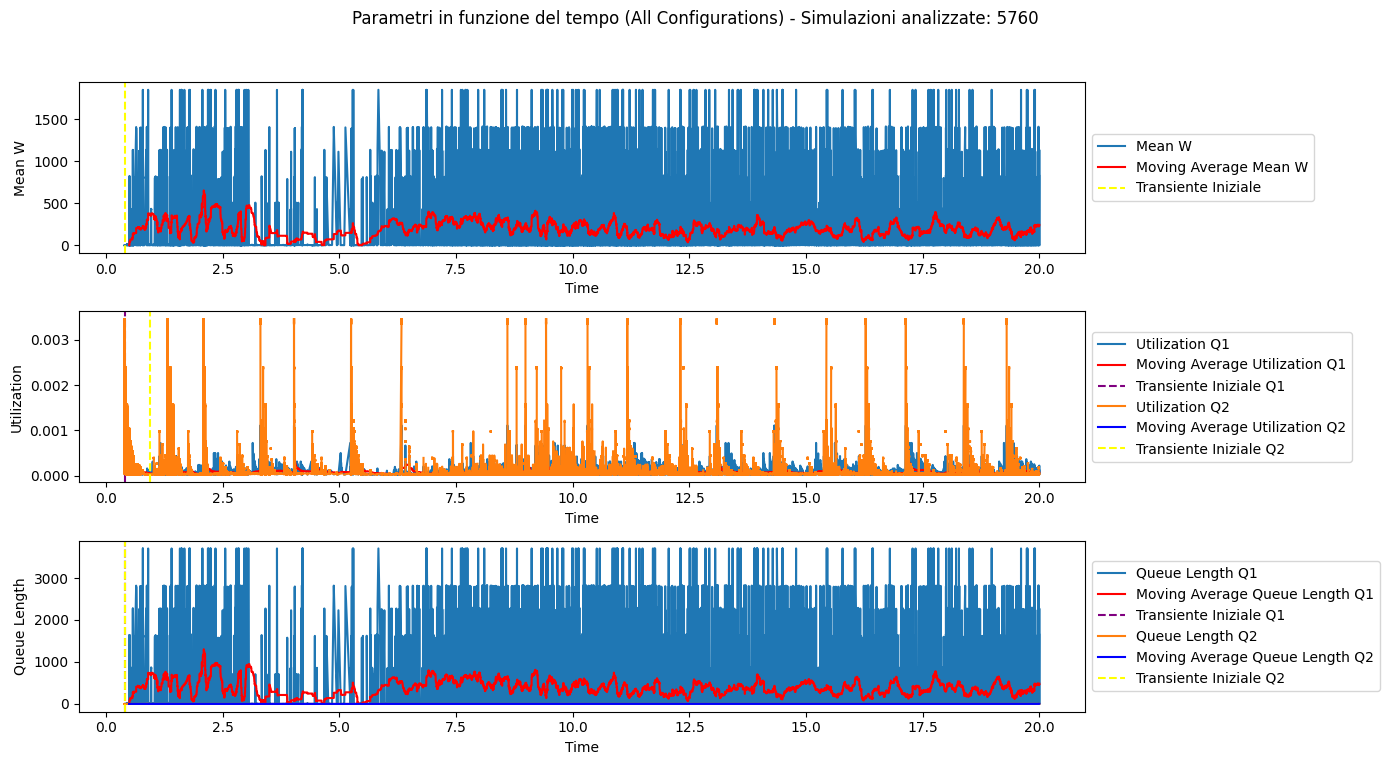

np.float64(0.5004797669114)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che il tuo dataframe si chiami 'results_df'
# Creiamo un dataframe dai dati forniti
results_df = pd.read_csv('./results_summary.csv')

# Convertiamo le colonne lifeTime e lifeTime_arrival da stringhe a liste di numeri
results_df['lifeTime'] = results_df['lifeTime'].apply(lambda x: list(map(float, x.split(','))))
results_df['lifeTime_arrival'] = results_df['lifeTime_arrival'].apply(lambda x: list(map(float, x.split(','))))

# Filtri aggiuntivi
parameters = [
    'Strategy=0', 'Strategy=1', 'lambda=1.0', 'lambda=1.2', 'lambda=1.4', 'lambda=2.0', 'm1=0.2', 'm1=0.25', 'm1=0.3', 'm1=0.4', 'm2=0.2', 'm2=0.25', 'm2=0.3', 'm2=0.4', 'N=1', 'N=2', 'N=3', 'N=4', 'N=5'
]

# Funzione per creare e visualizzare i plot per una determinata strategia o parametro
def plot_strategy(dataframe, label, window_size=1000, time_limit=20):
    # Ridurre il campione di dati analizzati
    sample_size = int(len(dataframe) * 1)
    sampled_df = dataframe.head(sample_size)
    
    # Creazione del DataFrame per i job completati in base al tempo di arrivo
    arrival_times = []
    mean_W_values = []
    utilization_Q1_values = []
    utilization_Q2_values = []
    queue_length_Q1_values = []
    queue_length_Q2_values = []

    for index, row in sampled_df.iterrows():
        arrival_times.extend(row['lifeTime_arrival'])
        mean_W_values.extend([row['mean_W']] * len(row['lifeTime_arrival']))
        utilization_Q1_values.extend([row['mean_utilization_Q1']] * len(row['lifeTime_arrival']))
        utilization_Q2_values.extend([row['mean_utilization_Q2']] * len(row['lifeTime_arrival']))
        queue_length_Q1_values.extend([row['mean_queueLength_Q1']] * len(row['lifeTime_arrival']))
        queue_length_Q2_values.extend([row['mean_queueLength_Q2']] * len(row['lifeTime_arrival']))

    # Creiamo un DataFrame per facilitare le operazioni
    time_df = pd.DataFrame({
        'arrival_time': arrival_times,
        'mean_W': mean_W_values,
        'utilization_Q1': utilization_Q1_values,
        'utilization_Q2': utilization_Q2_values,
        'queue_length_Q1': queue_length_Q1_values,
        'queue_length_Q2': queue_length_Q2_values
    })

    # Filtrare il DataFrame fino al tempo limite
    time_df = time_df[time_df['arrival_time'] <= time_limit]

    # Ordiniamo per tempo di arrivo
    time_df = time_df.sort_values(by='arrival_time').reset_index(drop=True)

    # Calcolo della media mobile per i parametri in funzione del tempo
    time_df['mean_W_moving_avg'] = time_df['mean_W'].rolling(window=window_size).mean()
    time_df['utilization_Q1_moving_avg'] = time_df['utilization_Q1'].rolling(window=window_size).mean()
    if 'utilization_Q2' in time_df:
        time_df['utilization_Q2_moving_avg'] = time_df['utilization_Q2'].rolling(window=window_size).mean()
    time_df['queue_length_Q1_moving_avg'] = time_df['queue_length_Q1'].rolling(window=window_size).mean()
    if 'queue_length_Q2' in time_df:
        time_df['queue_length_Q2_moving_avg'] = time_df['queue_length_Q2'].rolling(window=window_size).mean()

    # Metodo per calcolare il transiente iniziale basato sulla stabilizzazione della media mobile in funzione del tempo
    def calculate_transient_initial(time_series, value_series, window_size=100, threshold=0.01):
        moving_avg = value_series.rolling(window=window_size).mean()
        stabilization_point = None

        for i in range(window_size, len(moving_avg)):
            if np.abs(moving_avg[i] - moving_avg[i-1]) < threshold:
                stabilization_point = i
                break

        if stabilization_point is not None:
            return time_series[stabilization_point]
        else:
            return None

    # Calcoliamo il transiente iniziale per i parametri in funzione del tempo
    transient_initial_mean_W = calculate_transient_initial(time_df['arrival_time'], time_df['mean_W'])
    transient_initial_utilization_Q1 = calculate_transient_initial(time_df['arrival_time'], time_df['utilization_Q1'])
    transient_initial_queue_length_Q1 = calculate_transient_initial(time_df['arrival_time'], time_df['queue_length_Q1'])
    
    if 'utilization_Q2' in time_df:
        transient_initial_utilization_Q2 = calculate_transient_initial(time_df['arrival_time'], time_df['utilization_Q2'])
    else:
        transient_initial_utilization_Q2 = None

    if 'queue_length_Q2' in time_df:
        transient_initial_queue_length_Q2 = calculate_transient_initial(time_df['arrival_time'], time_df['queue_length_Q2'])
    else:
        transient_initial_queue_length_Q2 = None

    print(f'Transiente iniziale per mean_W ({label}): {transient_initial_mean_W}')
    print(f'Transiente iniziale per utilization_Q1 ({label}): {transient_initial_utilization_Q1}')
    if transient_initial_utilization_Q2 is not None:
        print(f'Transiente iniziale per utilization_Q2 ({label}): {transient_initial_utilization_Q2}')
    print(f'Transiente iniziale per queue_length_Q1 ({label}): {transient_initial_queue_length_Q1}')
    if transient_initial_queue_length_Q2 is not None:
        print(f'Transiente iniziale per queue_length_Q2 ({label}): {transient_initial_queue_length_Q2}')

    transient_values = [
        transient_initial_mean_W,
        transient_initial_utilization_Q1,
        transient_initial_utilization_Q2,
        transient_initial_queue_length_Q1,
        transient_initial_queue_length_Q2
    ]

    transient_values = [value for value in transient_values if value is not None]
    transient_average = np.mean(transient_values) if transient_values else None

    print(f'Media dei transienti iniziali ({label}): {transient_average}')

    # Numero di simulazioni analizzate
    num_simulations = len(sampled_df)

    # Grafico per visualizzare i parametri in funzione del tempo con il transiente iniziale annotato
    plt.figure(figsize=(14, 8))
    plt.suptitle(f'Parametri in funzione del tempo ({label}) - Simulazioni analizzate: {num_simulations}')
    
    plt.subplot(3, 1, 1)
    plt.plot(time_df['arrival_time'], time_df['mean_W'], label='Mean W')
    plt.plot(time_df['arrival_time'], time_df['mean_W_moving_avg'], label='Moving Average Mean W', color='red')
    if transient_initial_mean_W is not None:
        plt.axvline(x=transient_initial_mean_W, color='yellow', linestyle='--', label='Transiente Iniziale')
    plt.xlabel('Time')
    plt.ylabel('Mean W')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.subplot(3, 1, 2)
    plt.plot(time_df['arrival_time'], time_df['utilization_Q1'], label='Utilization Q1')
    plt.plot(time_df['arrival_time'], time_df['utilization_Q1_moving_avg'], label='Moving Average Utilization Q1', color='red')
    if transient_initial_utilization_Q1 is not None:
        plt.axvline(x=transient_initial_utilization_Q1, color='purple', linestyle='--', label='Transiente Iniziale Q1')
    if 'utilization_Q2' in time_df:
        plt.plot(time_df['arrival_time'], time_df['utilization_Q2'], label='Utilization Q2')
        plt.plot(time_df['arrival_time'], time_df['utilization_Q2_moving_avg'], label='Moving Average Utilization Q2', color='blue')
        if transient_initial_utilization_Q2 is not None:
            plt.axvline(x=transient_initial_utilization_Q2, color='yellow', linestyle='--', label='Transiente Iniziale Q2')
    plt.xlabel('Time')
    plt.ylabel('Utilization')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.subplot(3, 1, 3)
    plt.plot(time_df['arrival_time'], time_df['queue_length_Q1'], label='Queue Length Q1')
    plt.plot(time_df['arrival_time'], time_df['queue_length_Q1_moving_avg'], label='Moving Average Queue Length Q1', color='red')
    if transient_initial_queue_length_Q1 is not None:
        plt.axvline(x=transient_initial_queue_length_Q1, color='purple', linestyle='--', label='Transiente Iniziale Q1')
    if 'queue_length_Q2' in time_df:
        plt.plot(time_df['arrival_time'], time_df['queue_length_Q2'], label='Queue Length Q2')
        plt.plot(time_df['arrival_time'], time_df['queue_length_Q2_moving_avg'], label='Moving Average Queue Length Q2', color='blue')
        if transient_initial_queue_length_Q2 is not None:
            plt.axvline(x=transient_initial_queue_length_Q2, color='yellow', linestyle='--', label='Transiente Iniziale Q2')
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Utilizziamo il titolo del grafico come nome del file
    title = plt.gcf()._suptitle.get_text()
    plt.savefig(f'Analysis_Images/{title}.png')
    plt.savefig(f'Analysis_Images/{title}.eps')
    plt.show()

    return transient_average

# Analisi per tutte le configurazioni
plot_strategy(results_df, 'All Configurations')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


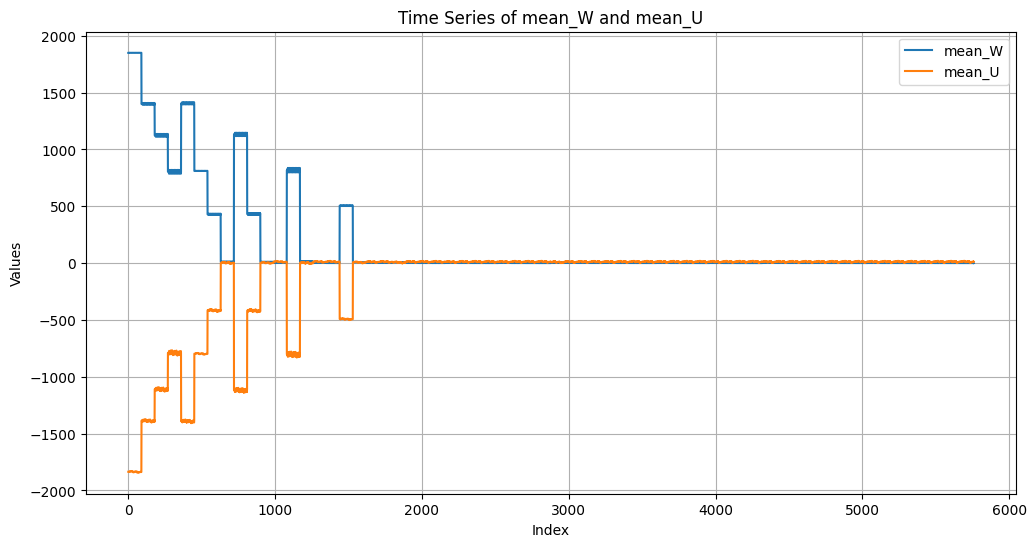

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


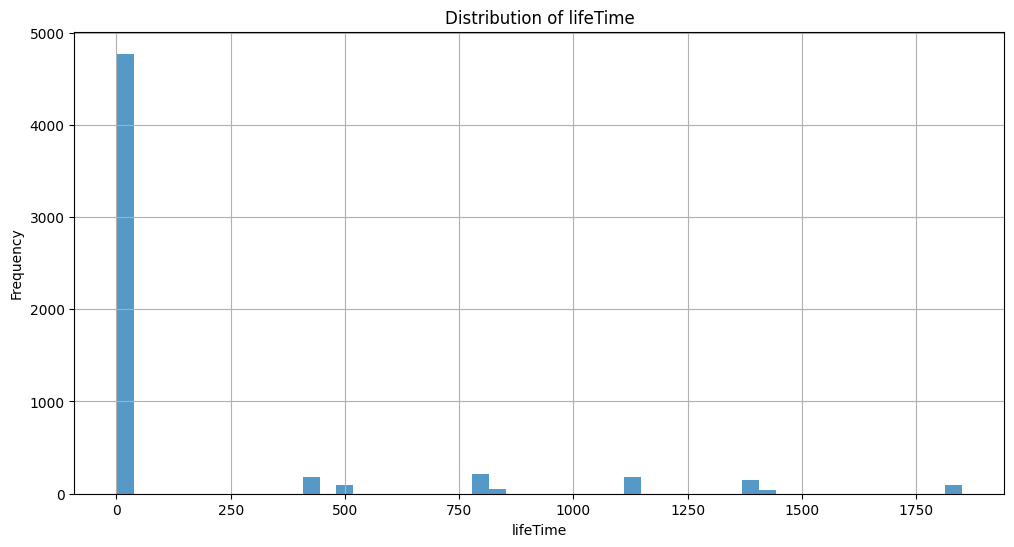

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


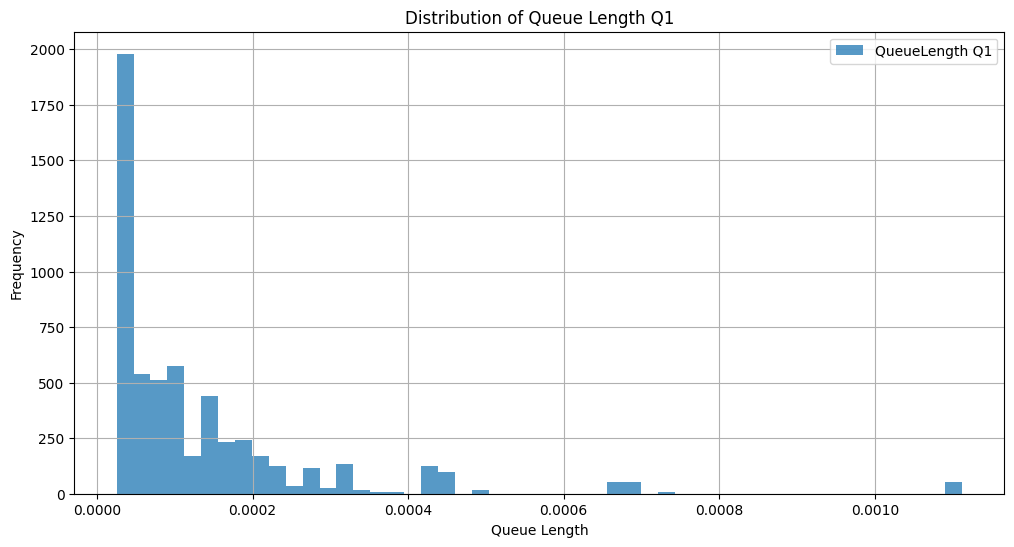

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


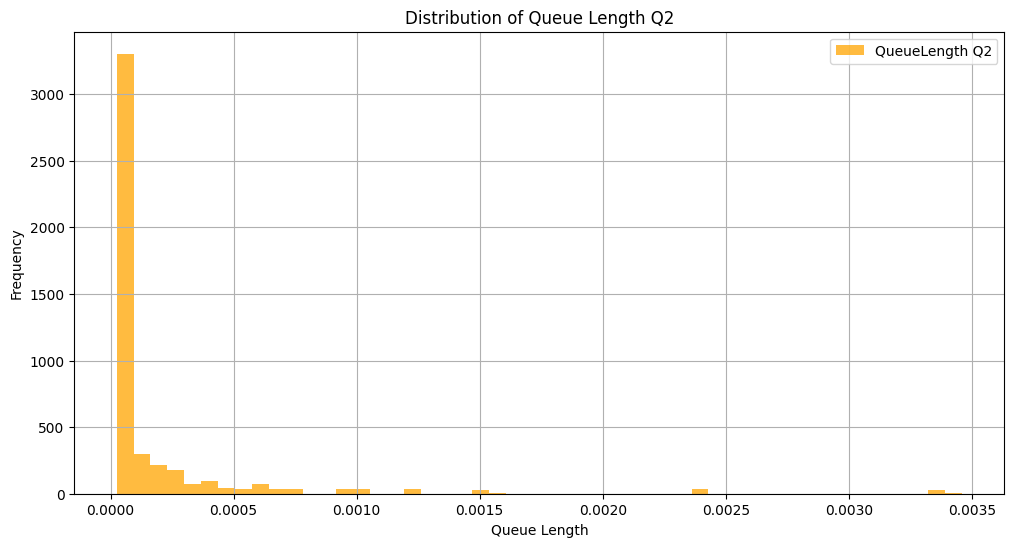

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


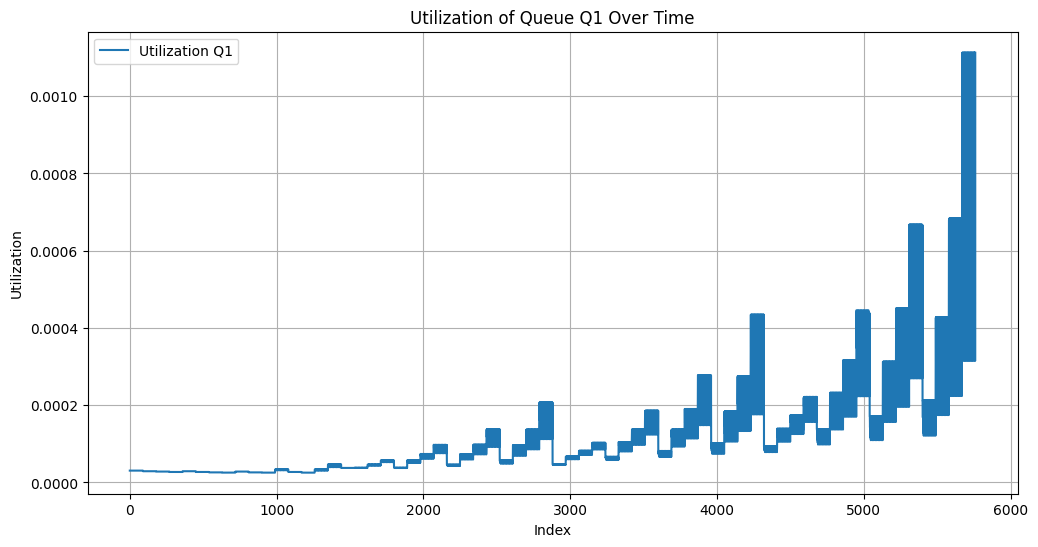

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


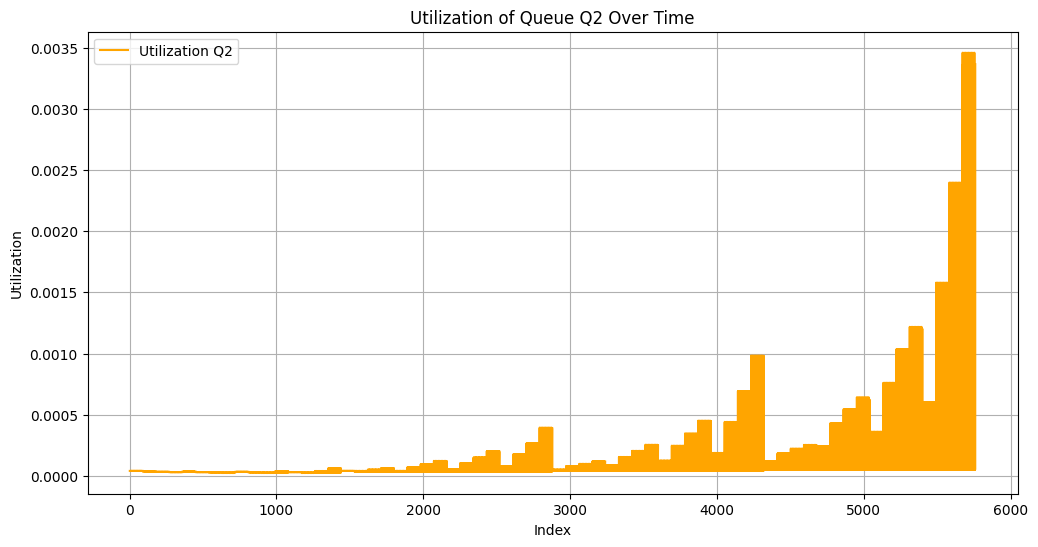

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtra i dati includendo solo le configurazioni con N da 1 a 5 nella descrizione
results_df = results_df[results_df['Description'].str.contains('N=')]

# Estrai i valori di N
results_df['N_value'] = results_df['Description'].str.extract(r'N=(\d+)').astype(int)

# Prepara i grafici

# Serie temporali di mean_W e mean_U
plt.figure(figsize=(12, 6))
plt.plot(results_df['mean_W'], label='mean_W')
plt.plot(results_df['mean_U'], label='mean_U')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Time Series of mean_W and mean_U')
plt.legend()
plt.grid(True)
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Distribuzione di lifeTime
lifeTime_values = results_df['mean_W']  # Utilizziamo mean_W come proxy per lifeTime
plt.figure(figsize=(12, 6))
plt.hist(lifeTime_values, bins=50, alpha=0.75)
plt.xlabel('lifeTime')
plt.ylabel('Frequency')
plt.title('Distribution of lifeTime')
plt.grid(True)
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Distribuzione di queueLength per Q1
queueLength_Q1 = results_df['mean_utilization_Q1']
plt.figure(figsize=(12, 6))
plt.hist(queueLength_Q1, bins=50, alpha=0.75, label='QueueLength Q1')
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.title('Distribution of Queue Length Q1')
plt.legend()
plt.grid(True)
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Distribuzione di queueLength per Q2
queueLength_Q2 = results_df['mean_utilization_Q2']
plt.figure(figsize=(12, 6))
plt.hist(queueLength_Q2, bins=50, alpha=0.75, label='QueueLength Q2', color='orange')
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.title('Distribution of Queue Length Q2')
plt.legend()
plt.grid(True)
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Utilizzo delle code Q1 nel tempo
plt.figure(figsize=(12, 6))
plt.plot(results_df['mean_utilization_Q1'], label='Utilization Q1')
plt.xlabel('Index')
plt.ylabel('Utilization')
plt.title('Utilization of Queue Q1 Over Time')
plt.legend()
plt.grid(True)
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Utilizzo delle code Q2 nel tempo
plt.figure(figsize=(12, 6))
plt.plot(results_df['mean_utilization_Q2'], label='Utilization Q2', color='orange')
plt.xlabel('Index')
plt.ylabel('Utilization')
plt.title('Utilization of Queue Q2 Over Time')
plt.legend()
plt.grid(True)
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


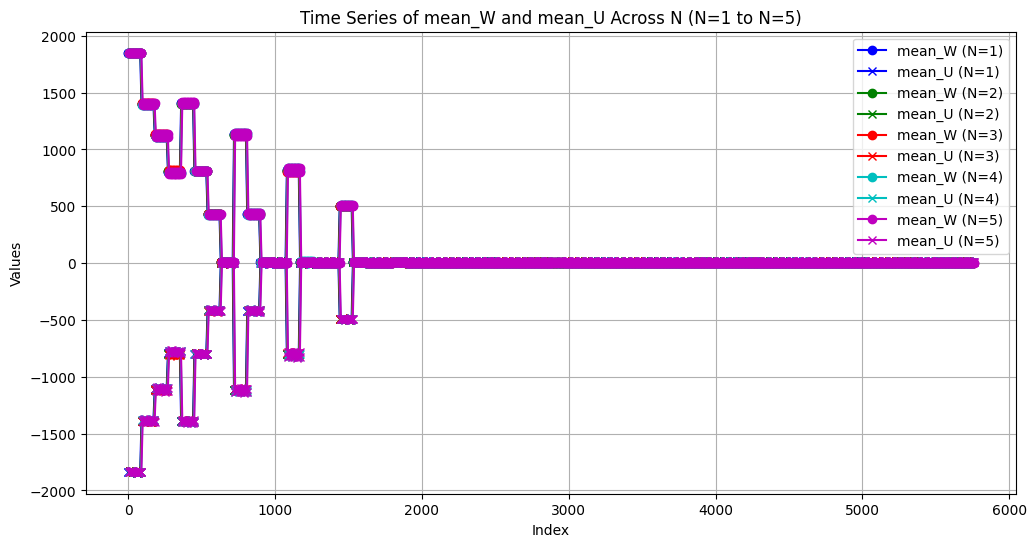

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


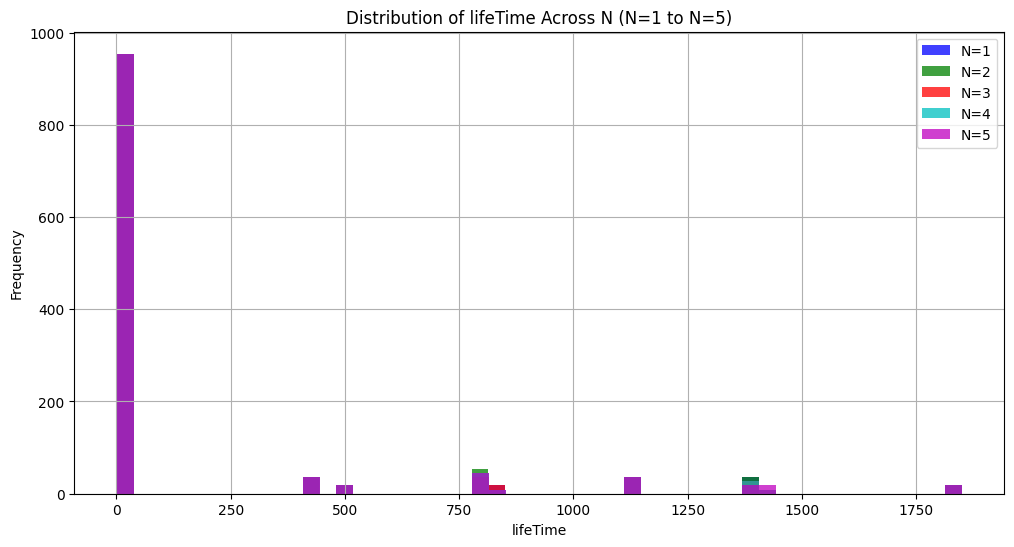

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


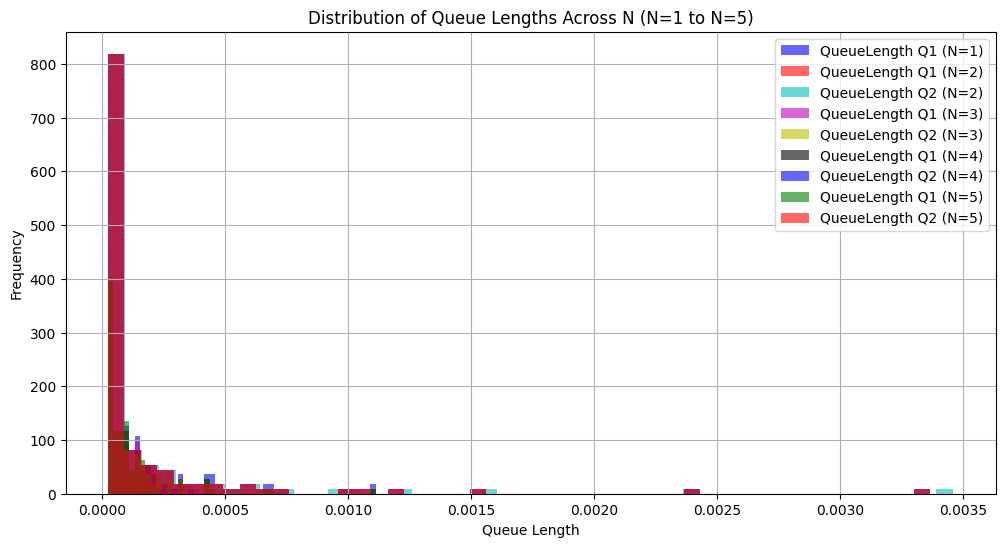

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


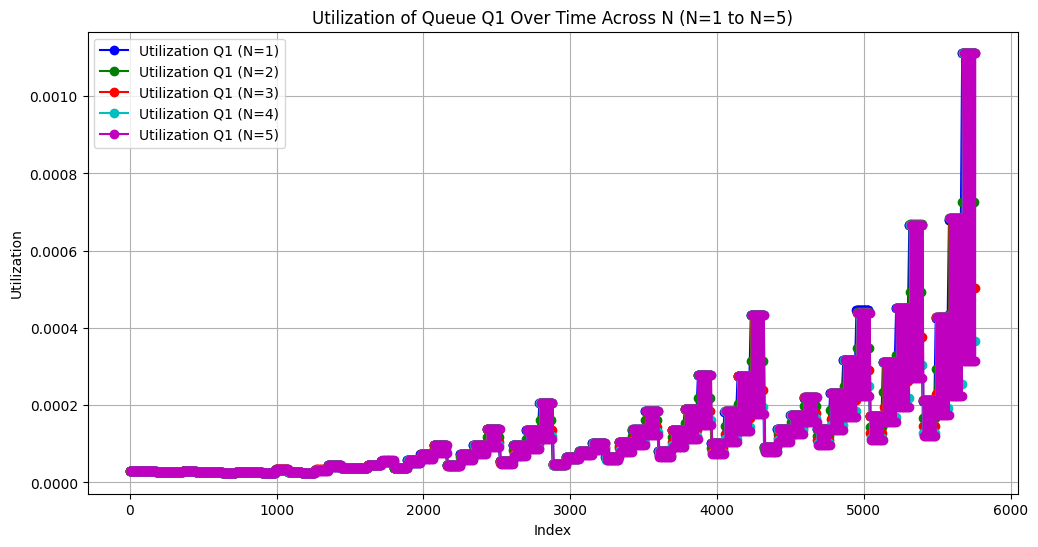

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


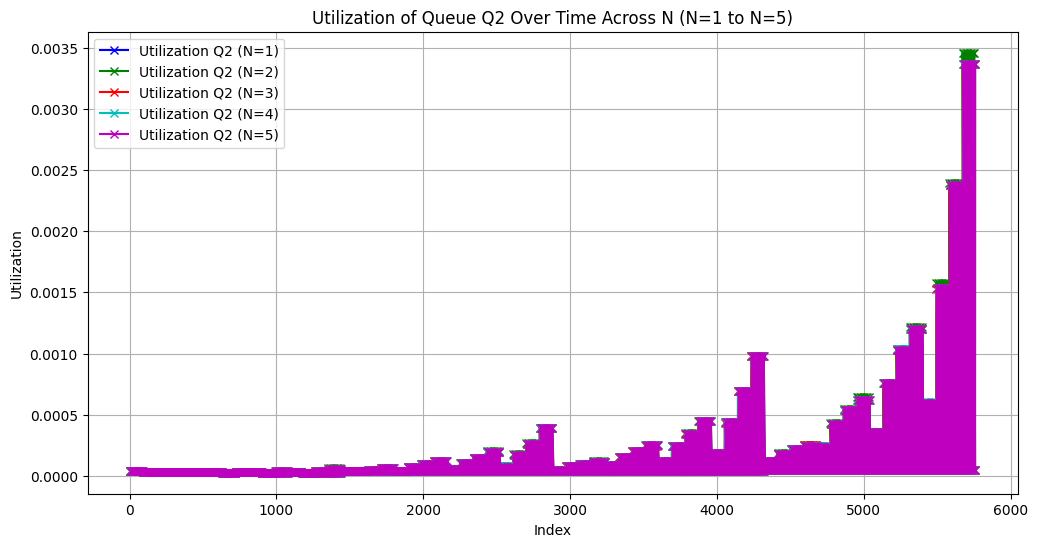

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtra i dati includendo solo le configurazioni con N da 1 a 5 nella descrizione
results_df = results_df[results_df['Description'].str.contains('N=')]

# Estrai i valori di N
results_df['N_value'] = results_df['Description'].str.extract(r'N=(\d+)').astype(int)

# Prepara i grafici

# Lista di colori
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Grafico: Serie temporali di mean_W e mean_U
plt.figure(figsize=(12, 6))
color_index = 0
for n in range(1, 6):
    subset = results_df[results_df['N_value'] == n]
    color = colors[color_index % len(colors)]
    color_index += 1
    plt.plot(subset.index, subset['mean_W'], label=f'mean_W (N={n})', marker='o', linestyle='-', color=color)
    plt.plot(subset.index, subset['mean_U'], label=f'mean_U (N={n})', marker='x', linestyle='-', color=color)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Time Series of mean_W and mean_U Across N (N=1 to N=5)')
plt.legend()
plt.grid(True)
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Grafico: Distribuzione di lifeTime (utilizziamo mean_W come proxy per lifeTime)
plt.figure(figsize=(12, 6))
color_index = 0
for n in range(1, 6):
    subset = results_df[results_df['N_value'] == n]
    color = colors[color_index % len(colors)]
    color_index += 1
    plt.hist(subset['mean_W'], bins=50, alpha=0.75, label=f'N={n}', color=color)
plt.xlabel('lifeTime')
plt.ylabel('Frequency')
plt.title('Distribution of lifeTime Across N (N=1 to N=5)')
plt.legend()
plt.grid(True)
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Grafico: Distribuzione di queueLength per Q1 e Q2
plt.figure(figsize=(12, 6))
color_index = 0
for n in range(1, 6):
    subset_Q1 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q1'].notnull())]
    subset_Q2 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q2'].notnull())]
    color_Q1 = colors[color_index % len(colors)]
    color_Q2 = colors[(color_index + 1) % len(colors)]
    color_index += 2
    plt.hist(subset_Q1['mean_utilization_Q1'], bins=50, alpha=0.6, label=f'QueueLength Q1 (N={n})', color=color_Q1)
    if n != 1:
        plt.hist(subset_Q2['mean_utilization_Q2'], bins=50, alpha=0.6, label=f'QueueLength Q2 (N={n})', color=color_Q2)
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.title('Distribution of Queue Lengths Across N (N=1 to N=5)')
plt.legend()
plt.grid(True)
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.png') 
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.eps') 
plt.show()

# Grafico: Utilizzo delle code Q1 nel tempo
plt.figure(figsize=(12, 6))
color_index = 0
for n in range(1, 6):
    subset_Q1 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q1'].notnull())]
    color = colors[color_index % len(colors)]
    color_index += 1
    plt.plot(subset_Q1.index, subset_Q1['mean_utilization_Q1'], label=f'Utilization Q1 (N={n})', marker='o', linestyle='-', color=color)
plt.xlabel('Index')
plt.ylabel('Utilization')
plt.title('Utilization of Queue Q1 Over Time Across N (N=1 to N=5)')
plt.legend()
plt.grid(True)
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.eps')
plt.show()

# Grafico: Utilizzo delle code Q2 nel tempo
plt.figure(figsize=(12, 6))
color_index = 0
for n in range(1, 6):
    subset_Q2 = results_df[(results_df['N_value'] == n) & (results_df['mean_utilization_Q2'].notnull())]
    color = colors[color_index % len(colors)]
    color_index += 1
    plt.plot(subset_Q2.index, subset_Q2['mean_utilization_Q2'], label=f'Utilization Q2 (N={n})', marker='x', linestyle='-', color=color)
plt.xlabel('Index')
plt.ylabel('Utilization')
plt.title('Utilization of Queue Q2 Over Time Across N (N=1 to N=5)')
plt.legend()
plt.grid(True)
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.png')
plt.savefig('Analysis_Images/' + plt.gca().get_title() + '.eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


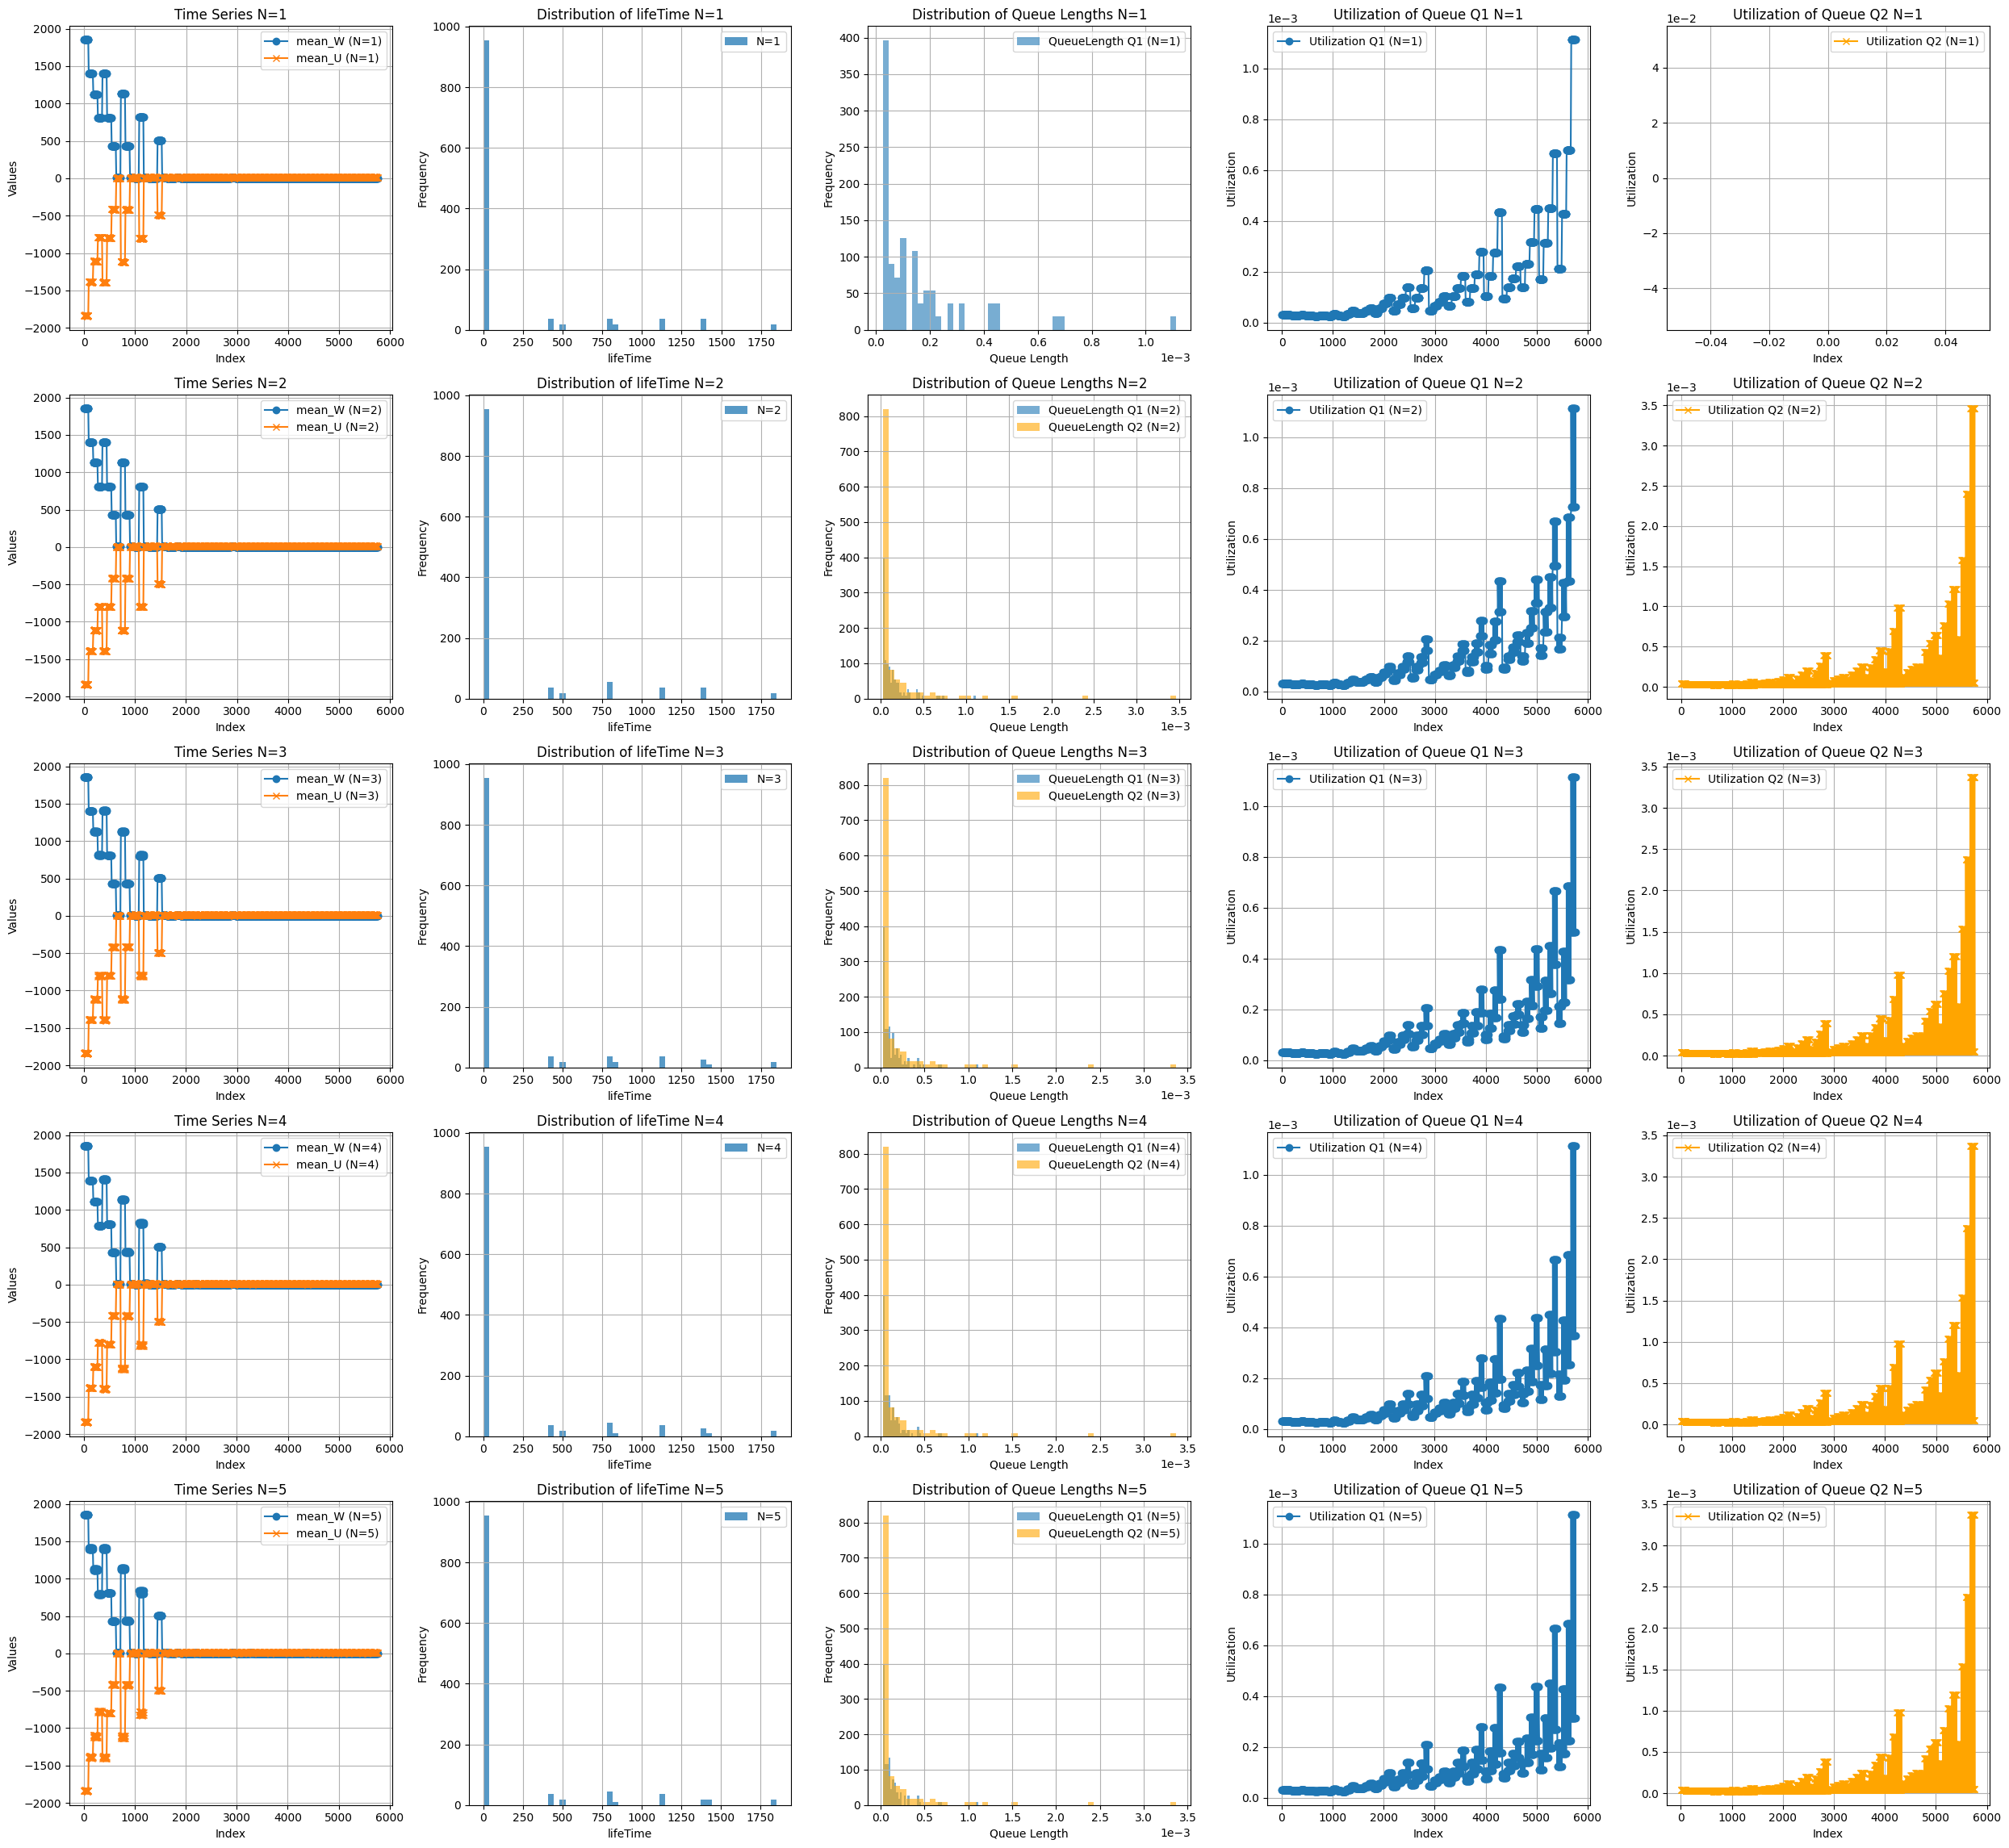

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


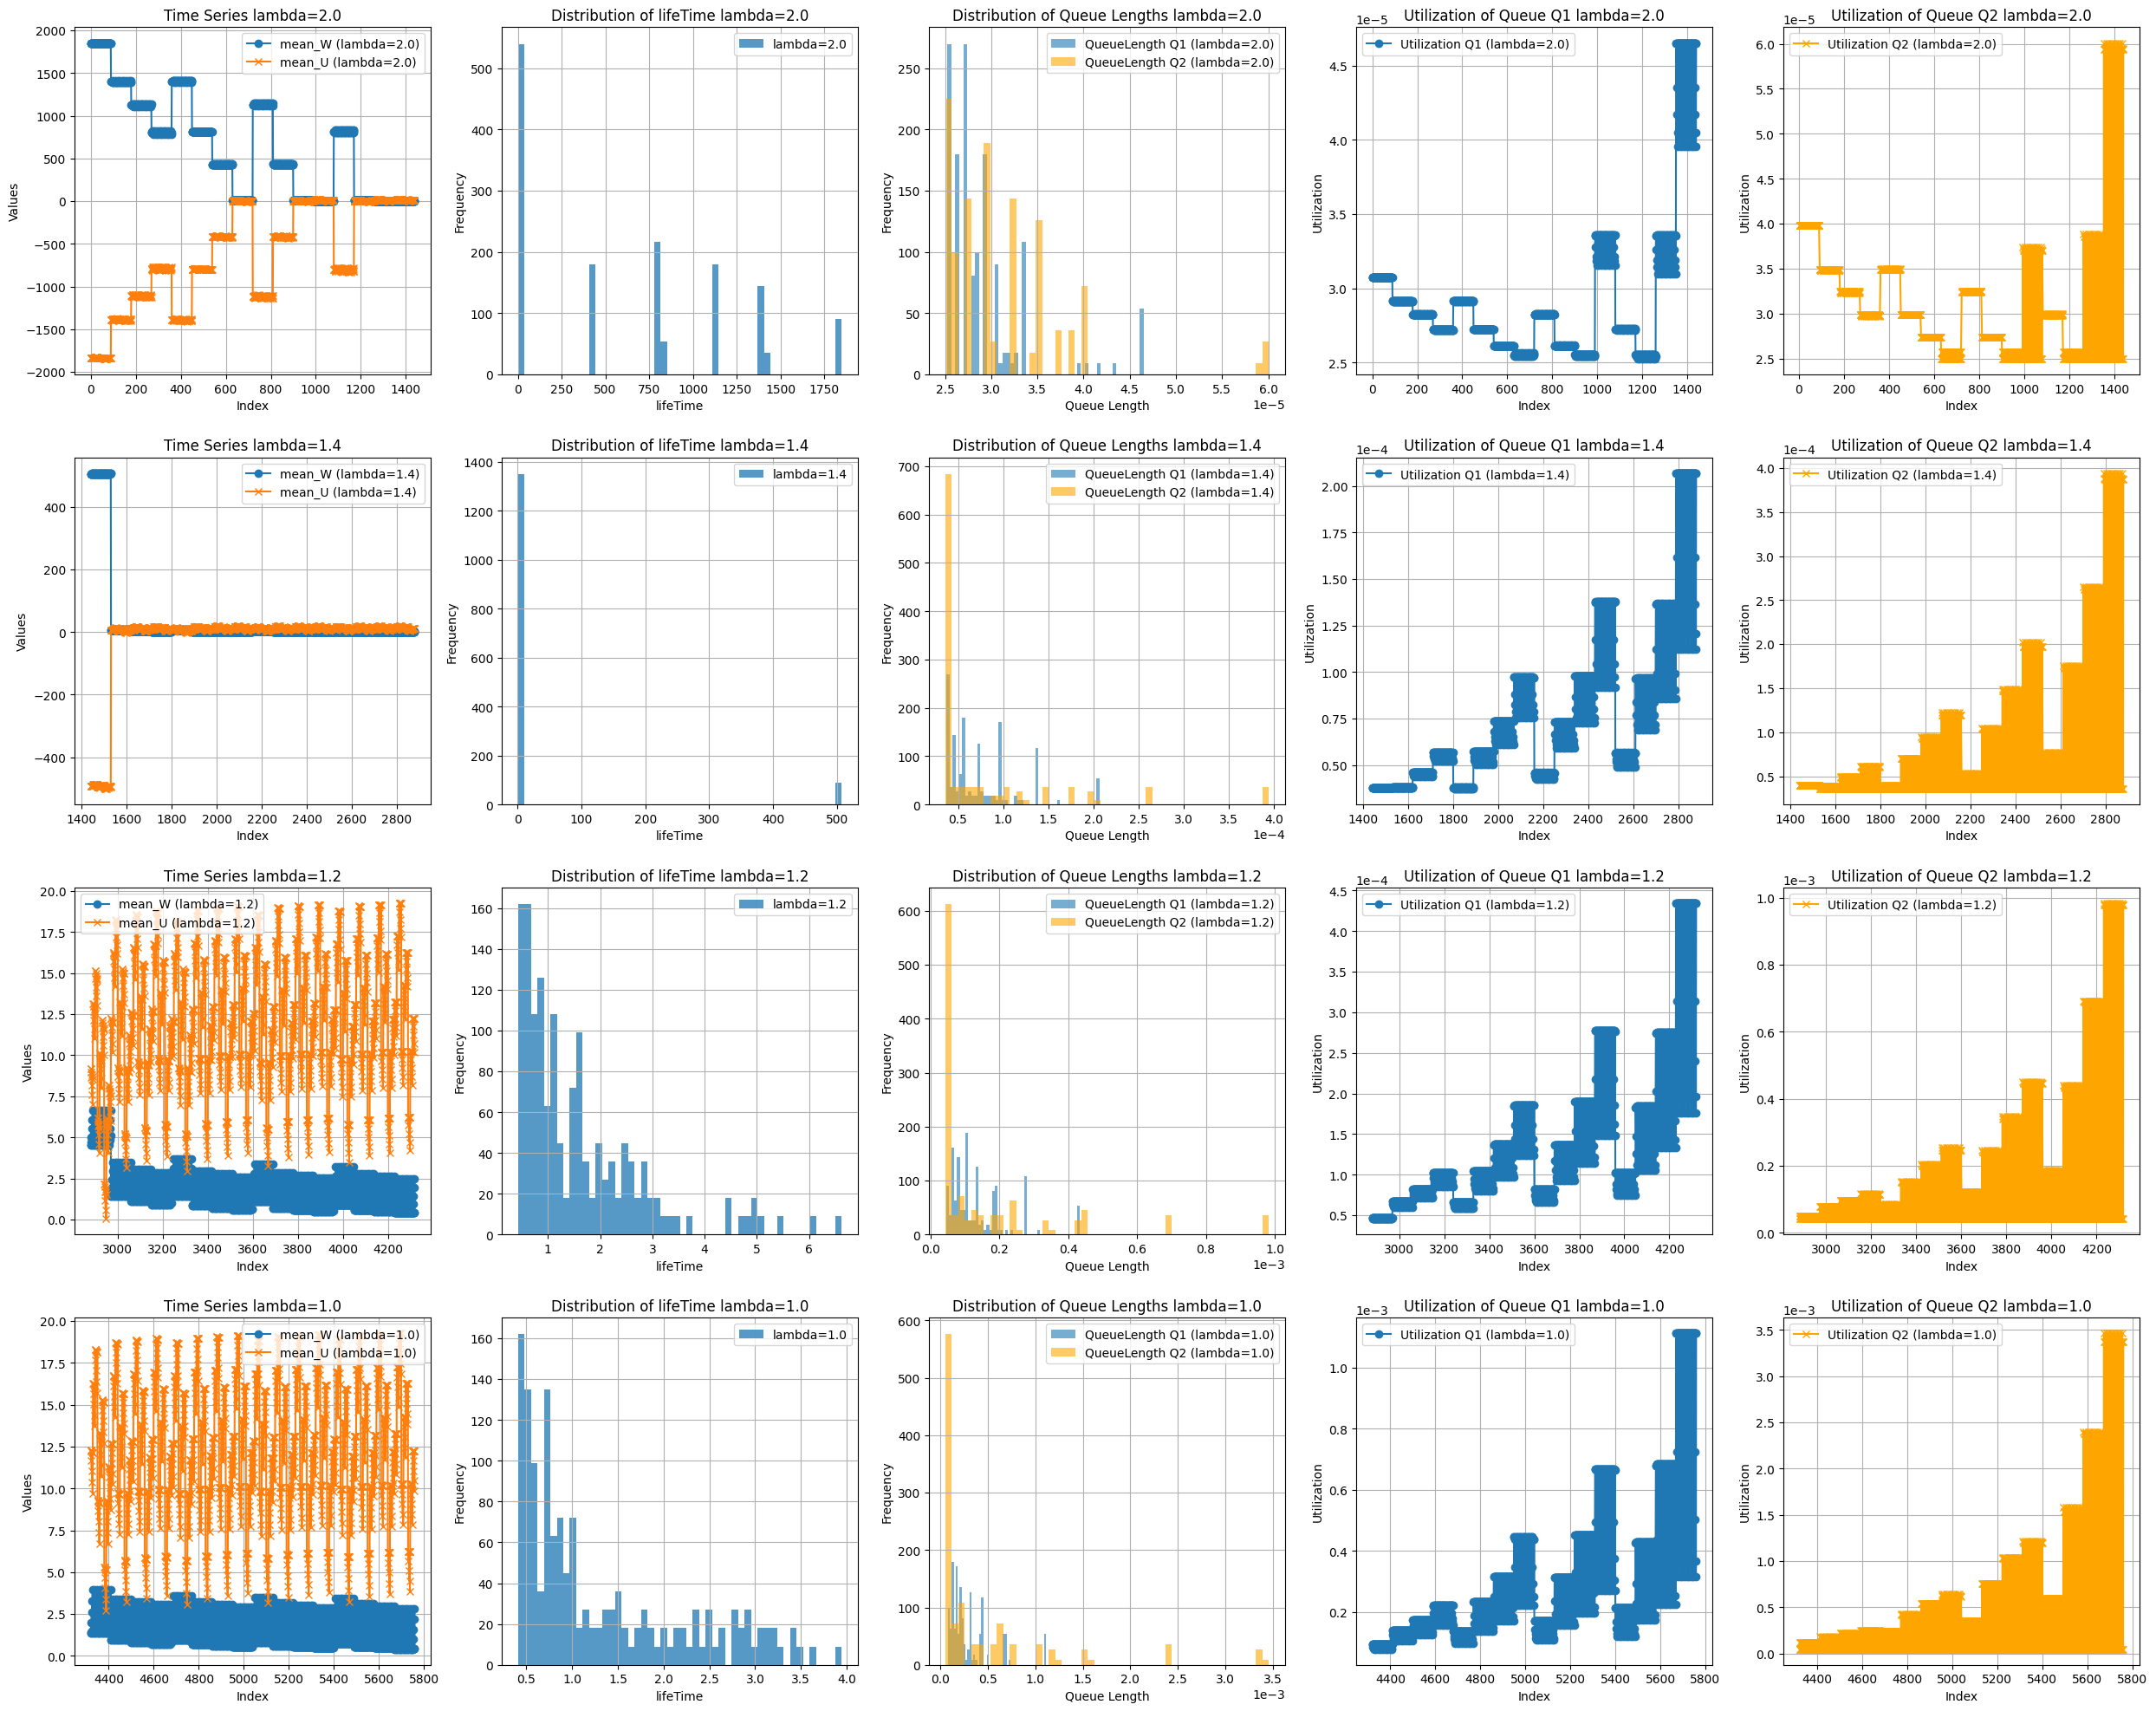

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


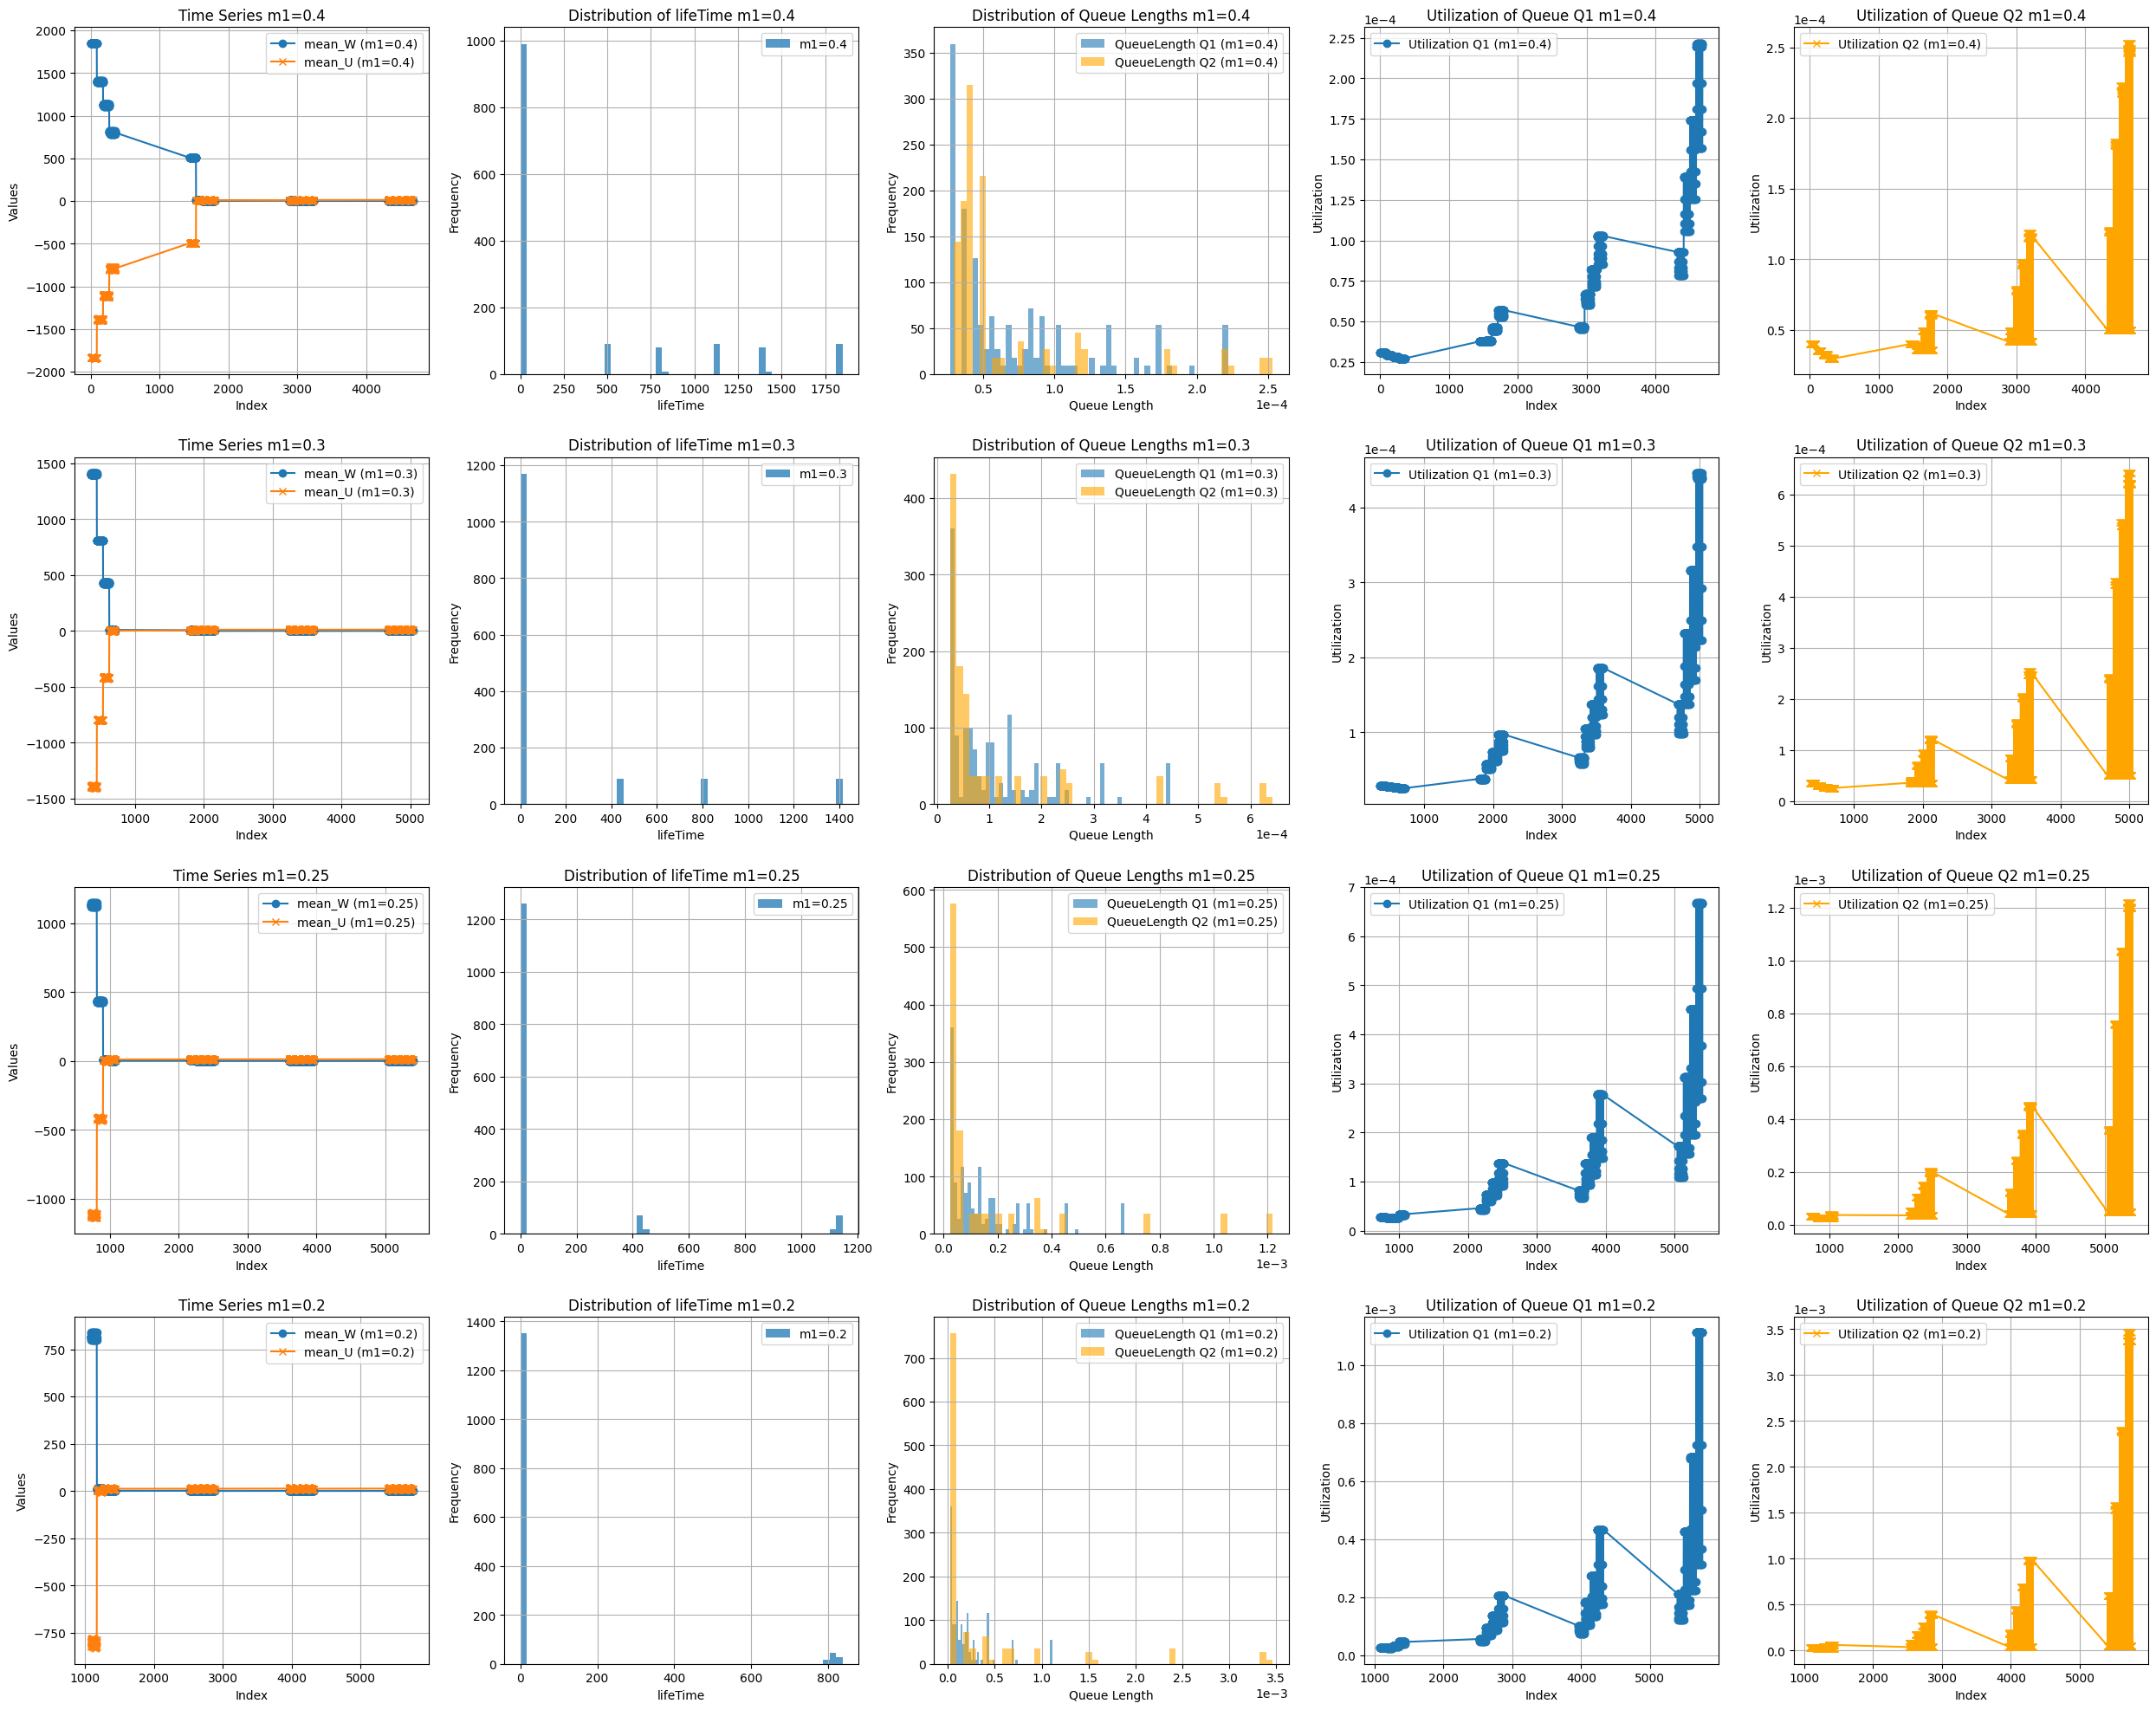

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


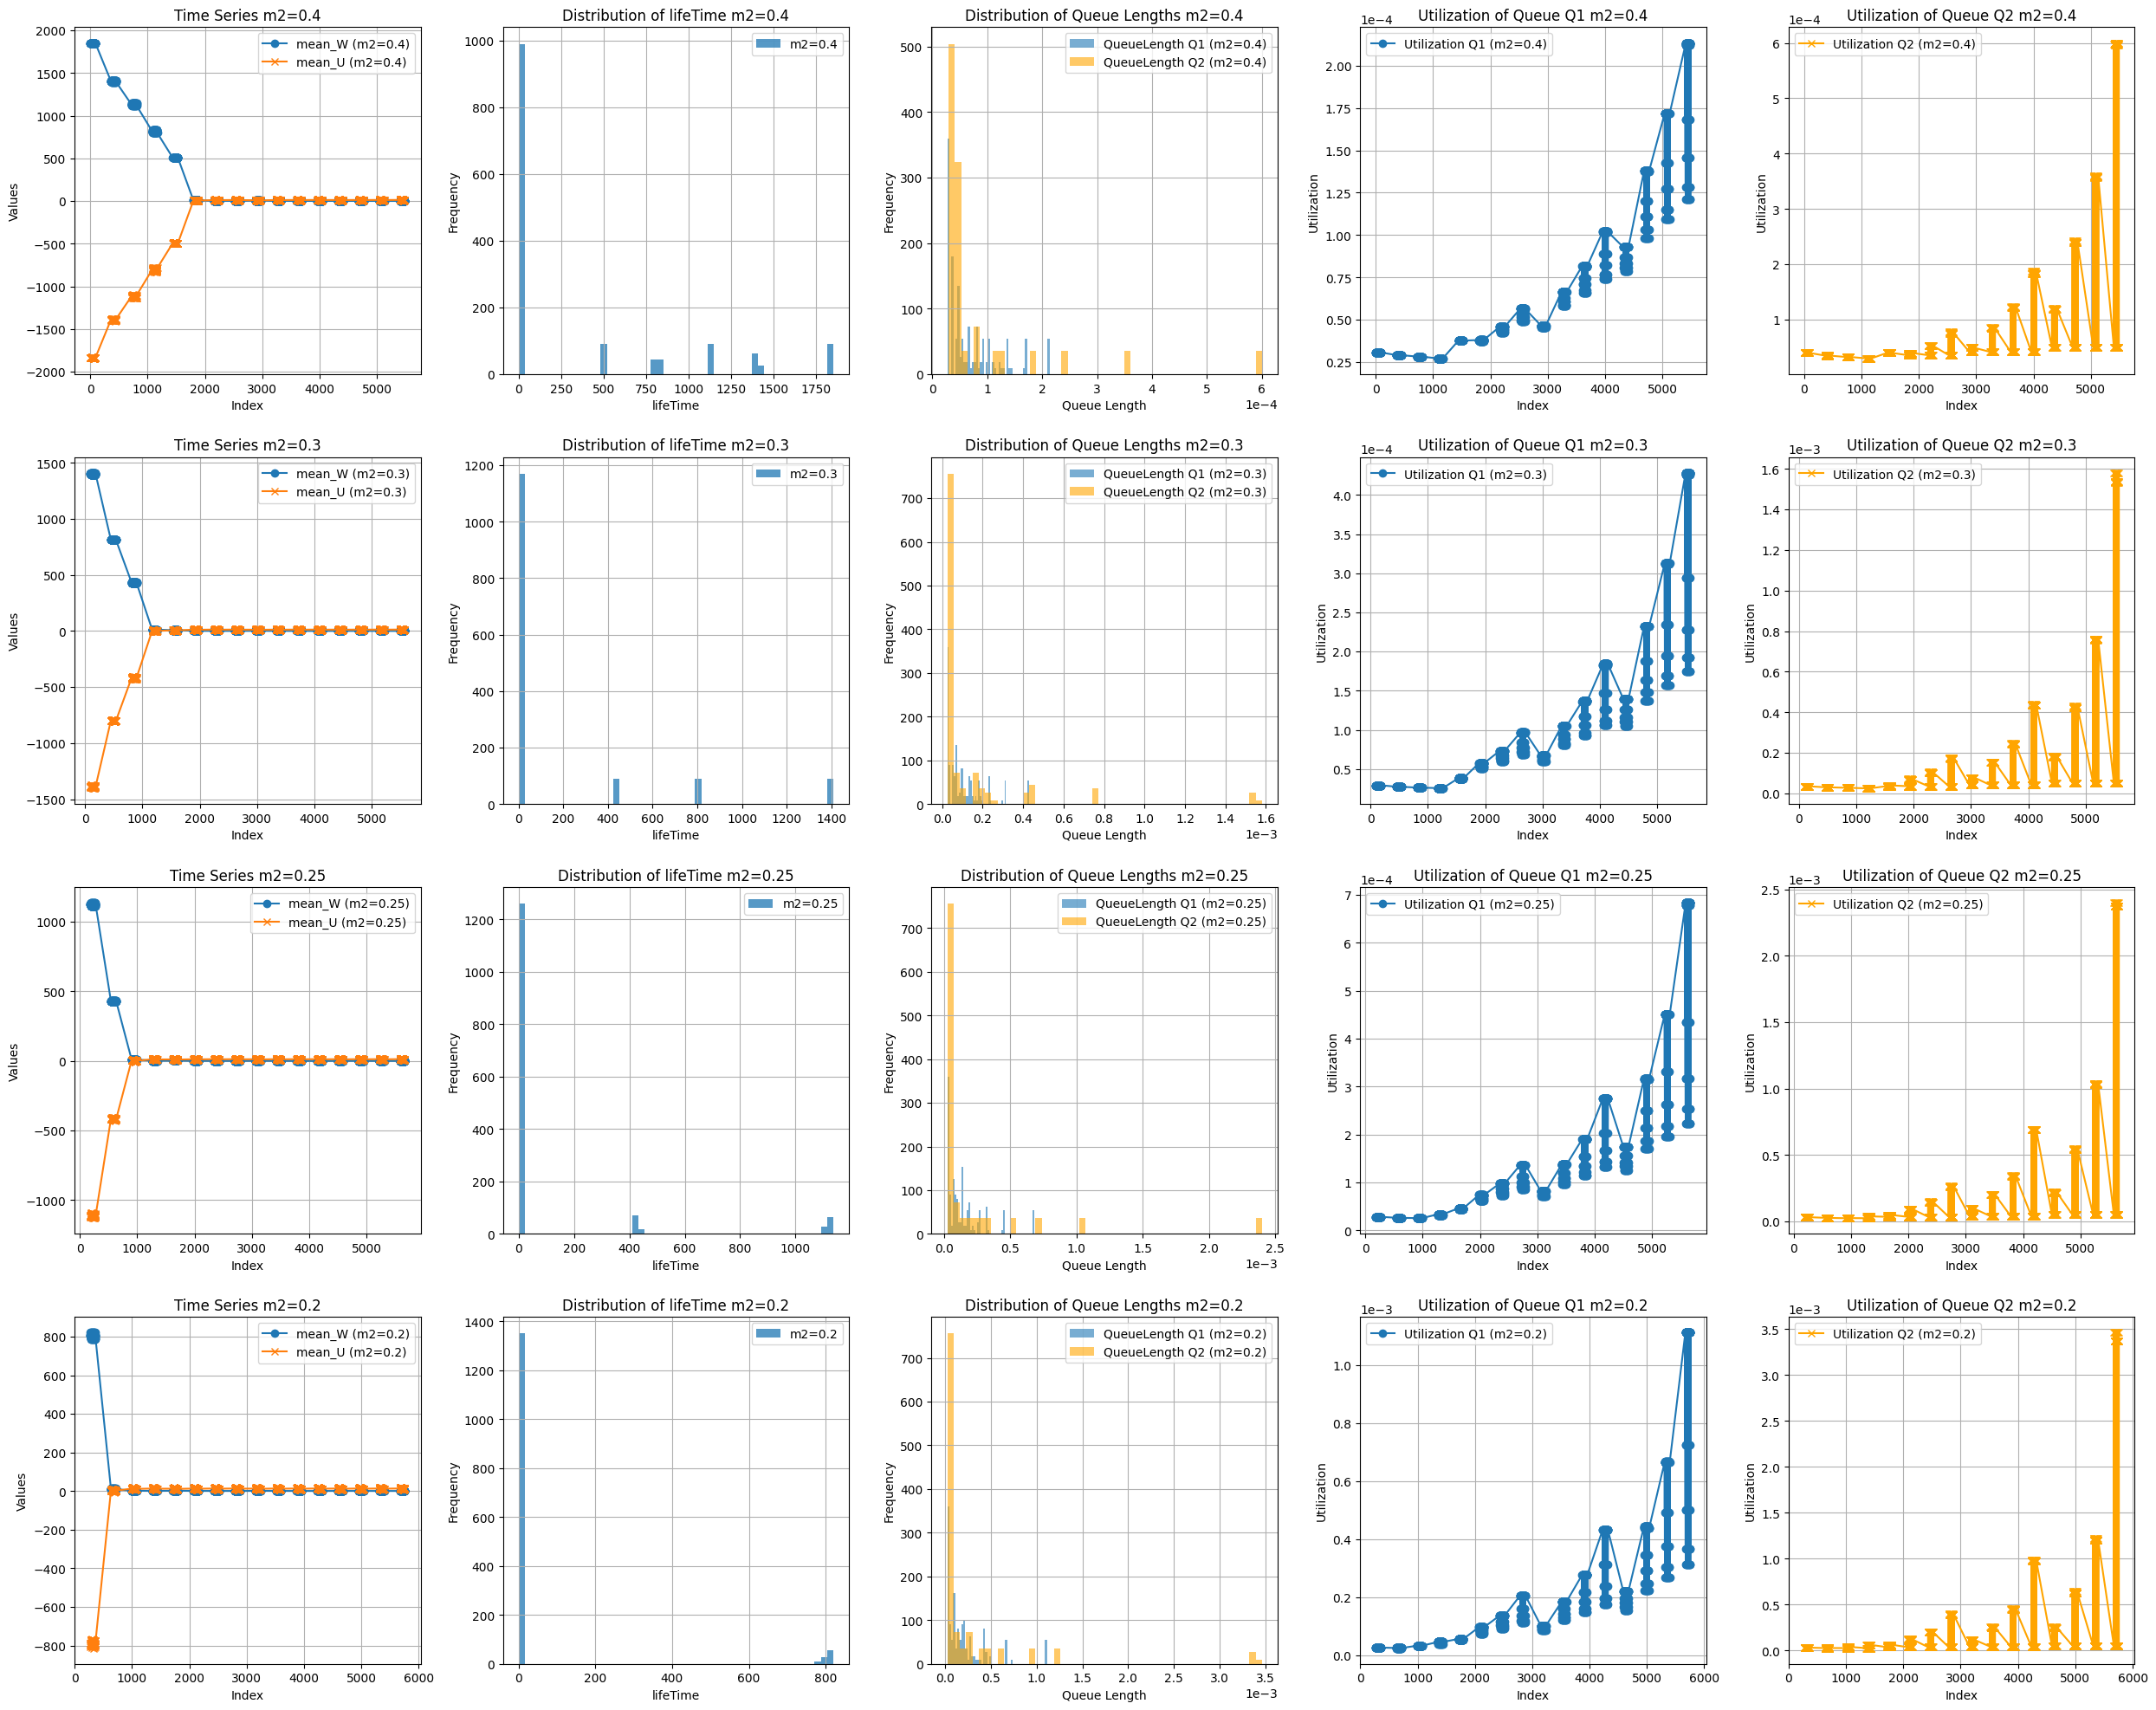

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtra i dati includendo solo le configurazioni con N, lambda, m1 e m2 nella descrizione
results_df_N = results_df[results_df['Description'].str.contains('N=')]
results_df_lambda = results_df[results_df['Description'].str.contains('lambda=')]
results_df_m1 = results_df[results_df['Description'].str.contains('m1=')]
results_df_m2 = results_df[results_df['Description'].str.contains('m2=')]

# Estrai i valori di N, lambda, m1 e m2
results_df_N['N_value'] = results_df_N['Description'].str.extract(r'N=(\d+)').astype(int)
results_df_lambda['lambda_value'] = results_df_lambda['Description'].str.extract(r'lambda=(\d+\.?\d*)').astype(float)
results_df_m1['m1_value'] = results_df_m1['Description'].str.extract(r'm1=(\d+\.?\d*)').astype(float)
results_df_m2['m2_value'] = results_df_m2['Description'].str.extract(r'm2=(\d+\.?\d*)').astype(float)

# Funzione per creare i grafici
def create_plots(subset, row, label, axs):
    # Grafico 1: Serie temporali di mean_W e mean_U
    axs[row, 0].plot(subset.index, subset['mean_W'], label=f'mean_W ({label})', marker='o')
    axs[row, 0].plot(subset.index, subset['mean_U'], label=f'mean_U ({label})', marker='x')
    axs[row, 0].set_xlabel('Index')
    axs[row, 0].set_ylabel('Values')
    axs[row, 0].set_title(f'Time Series {label}')
    axs[row, 0].legend()
    axs[row, 0].grid(True)

    # Grafico 2: Distribuzione di lifeTime (mean_W come proxy)
    axs[row, 1].hist(subset['mean_W'], bins=50, alpha=0.75, label=f'{label}')
    axs[row, 1].set_xlabel('lifeTime')
    axs[row, 1].set_ylabel('Frequency')
    axs[row, 1].set_title(f'Distribution of lifeTime {label}')
    axs[row, 1].legend()
    axs[row, 1].grid(True)

    # Grafico 3: Distribuzione di queueLength per Q1 e Q2
    subset_Q1 = subset[subset['mean_utilization_Q1'].notnull()]
    subset_Q2 = subset[subset['mean_utilization_Q2'].notnull()]
    axs[row, 2].hist(subset_Q1['mean_utilization_Q1'], bins=50, alpha=0.6, label=f'QueueLength Q1 ({label})')
    if not subset_Q2.empty:
        axs[row, 2].hist(subset_Q2['mean_utilization_Q2'], bins=50, alpha=0.6, label=f'QueueLength Q2 ({label})', color='orange')
    axs[row, 2].set_xlabel('Queue Length')
    axs[row, 2].set_ylabel('Frequency')
    axs[row, 2].set_title(f'Distribution of Queue Lengths {label}')
    axs[row, 2].legend()
    axs[row, 2].grid(True)
    axs[row, 2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    # Grafico 4: Utilizzo delle code Q1 nel tempo
    axs[row, 3].plot(subset_Q1.index, subset_Q1['mean_utilization_Q1'], label=f'Utilization Q1 ({label})', marker='o')
    axs[row, 3].set_xlabel('Index')
    axs[row, 3].set_ylabel('Utilization')
    axs[row, 3].set_title(f'Utilization of Queue Q1 {label}')
    axs[row, 3].legend()
    axs[row, 3].grid(True)
    axs[row, 3].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # Grafico 5: Utilizzo delle code Q2 nel tempo
    axs[row, 4].plot(subset_Q2.index, subset_Q2['mean_utilization_Q2'], label=f'Utilization Q2 ({label})', marker='x', color='orange')
    axs[row, 4].set_xlabel('Index')
    axs[row, 4].set_ylabel('Utilization')
    axs[row, 4].set_title(f'Utilization of Queue Q2 {label}')
    axs[row, 4].legend()
    axs[row, 4].grid(True)
    axs[row, 4].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Creazione e salvataggio dei grafici per N
fig_N, axs_N = plt.subplots(5, 5, figsize=(25, 23))
for i, n in enumerate(range(1, 6)):
    subset = results_df_N[results_df_N['N_value'] == n]
    create_plots(subset, i, f'N={n}', axs_N)
plt.tight_layout()
plt.savefig('Analysis_Images/Analysis_N.png')
plt.savefig('Analysis_Images/Analysis_N.eps')
plt.show()

# Creazione e salvataggio dei grafici per lambda
fig_lambda, axs_lambda = plt.subplots(4, 5, figsize=(25, 20))
for i, lambda_val in enumerate([2.0, 1.4, 1.2, 1.0]):
    subset = results_df_lambda[results_df_lambda['lambda_value'] == lambda_val]
    create_plots(subset, i, f'lambda={lambda_val}', axs_lambda)
plt.tight_layout()
plt.savefig('Analysis_Images/Analysis_lambda.png')
plt.savefig('Analysis_Images/Analysis_lambda.eps')
plt.show()

# Creazione e salvataggio dei grafici per m1
fig_m1, axs_m1 = plt.subplots(4, 5, figsize=(25, 20))
for i, m1_val in enumerate([0.4, 0.3, 0.25, 0.2]):
    subset = results_df_m1[results_df_m1['m1_value'] == m1_val]
    create_plots(subset, i, f'm1={m1_val}', axs_m1)
plt.tight_layout()
plt.savefig('Analysis_Images/Analysis_m1.png')
plt.savefig('Analysis_Images/Analysis_m1.eps')
plt.show()

# Creazione e salvataggio dei grafici per m2
fig_m2, axs_m2 = plt.subplots(4, 5, figsize=(25, 20))
for i, m2_val in enumerate([0.4, 0.3, 0.25, 0.2]):
    subset = results_df_m2[results_df_m2['m2_value'] == m2_val]
    create_plots(subset, i, f'm2={m2_val}', axs_m2)
plt.tight_layout()
plt.savefig('Analysis_Images/Analysis_m2.png')
plt.savefig('Analysis_Images/Analysis_m2.eps')
plt.show()
